In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/test.csv


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             classification_report, precision_recall_curve, 
                             average_precision_score, accuracy_score, precision_score, recall_score, f1_score)
import warnings
warnings.filterwarnings('ignore')

# For models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [8]:
df = pd.read_csv('/kaggle/input/playground-series-s6e2/train.csv')
df.head(5)

id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   0   58    1                4  152          239             0            0   
1   1   52    1                1  125          325             0            2   
2   2   56    0                2  160          188             0            2   
3   3   44    0                3  134          229             0            2   
4   4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium Heart Disease  
0                        2         7      Presence  
1                        0         3       Absence  
2                        0         3       Absence  
3                        0         3       Absence  
4                        3         3      Presence

In [9]:
df.columns

Index(['id', 'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
       'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
       'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium',
       'Heart Disease'],
      dtype='object')

In [10]:
df.shape

(630000, 15)

In [11]:
test_df = pd.read_csv('/kaggle/input/playground-series-s6e2/test.csv')
test_df.head(5)

id  Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  \
0  630000   58    1                3  120          288             0   
1  630001   55    0                2  120          209             0   
2  630002   54    1                4  120          268             0   
3  630003   44    0                3  112          177             0   
4  630004   43    1                1  138          267             0   

   EKG results  Max HR  Exercise angina  ST depression  Slope of ST  \
0            2     145                1            0.8            2   
1            0     172                0            0.0            1   
2            0     150                1            0.0            2   
3            0     168                0            0.9            1   
4            0     163                0            1.8            2   

   Number of vessels fluro  Thallium  
0                        3         3  
1                        0         3  
2                        3         7  
3                        0         3  
4                        0         7

In [12]:
test_df.shape

(270000, 14)

In [13]:
train_ids = df['id']
test_ids = test_df['id']

# EDA

In [14]:
def eda(df):
    
    print("="*20, "INFO", "="*20)
    df.info()
    print("="*20, "Description", "="*20)
    print(df.describe())

    print(df.dtypes)
    
    print("="*20, "NUll Values", "="*20)
    print(df.isnull().sum())
    
    print("="*20, "Null Percentage", "="*20)
    print(df.isnull().sum() / len(df) * 100)

    print("="*20, "Duplicates", "="*20)
    print(df.duplicated().sum())

In [15]:
eda(df)

==================== INFO ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       630000 non-null  int64  
 1   Age                      630000 non-null  int64  
 2   Sex                      630000 non-null  int64  
 3   Chest pain type          630000 non-null  int64  
 4   BP                       630000 non-null  int64  
 5   Cholesterol              630000 non-null  int64  
 6   FBS over 120             630000 non-null  int64  
 7   EKG results              630000 non-null  int64  
 8   Max HR                   630000 non-null  int64  
 9   Exercise angina          630000 non-null  int64  
 10  ST depression            630000 non-null  float64
 11  Slope of ST              630000 non-null  int64  
 12  Number of vessels fluro  630000 non-null  int64  
 13  Thallium    

In [16]:
eda(test_df)

==================== INFO ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       270000 non-null  int64  
 1   Age                      270000 non-null  int64  
 2   Sex                      270000 non-null  int64  
 3   Chest pain type          270000 non-null  int64  
 4   BP                       270000 non-null  int64  
 5   Cholesterol              270000 non-null  int64  
 6   FBS over 120             270000 non-null  int64  
 7   EKG results              270000 non-null  int64  
 8   Max HR                   270000 non-null  int64  
 9   Exercise angina          270000 non-null  int64  
 10  ST depression            270000 non-null  float64
 11  Slope of ST              270000 non-null  int64  
 12  Number of vessels fluro  270000 non-null  int64  
 13  Thallium    

Text(0.5, 1.0, 'Distribution of Heart Disease (Check for Imbalance)')

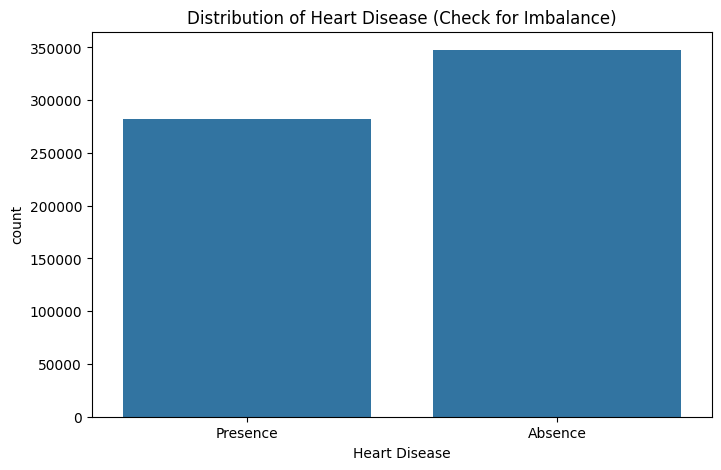

In [17]:
# Class distribution
df['Heart Disease'].value_counts()
df['Heart Disease'].value_counts(normalize=True) * 100


plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Heart Disease')
plt.title('Distribution of Heart Disease (Check for Imbalance)')

Age: 1048 outliers (0.17%)
BP: 9011 outliers (1.43%)
Cholesterol: 2194 outliers (0.35%)
Max HR: 14246 outliers (2.26%)
ST depression: 9971 outliers (1.58%)
Number of vessels fluro: 22857 outliers (3.63%)


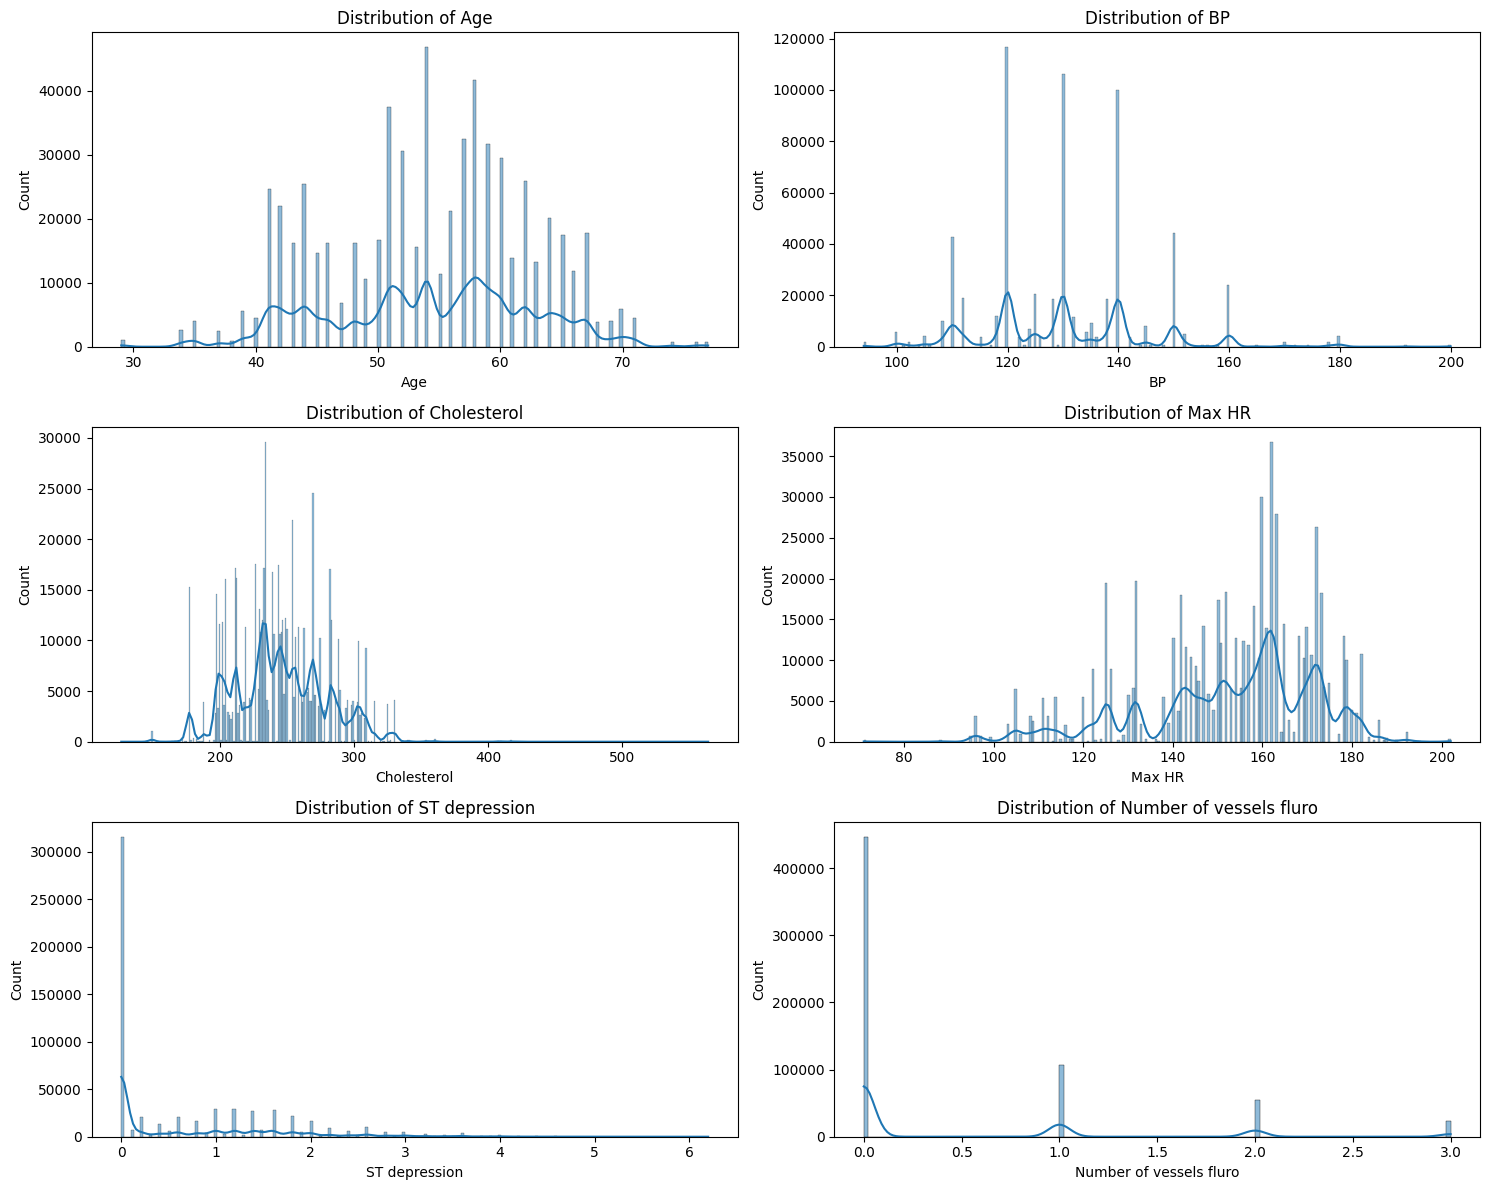

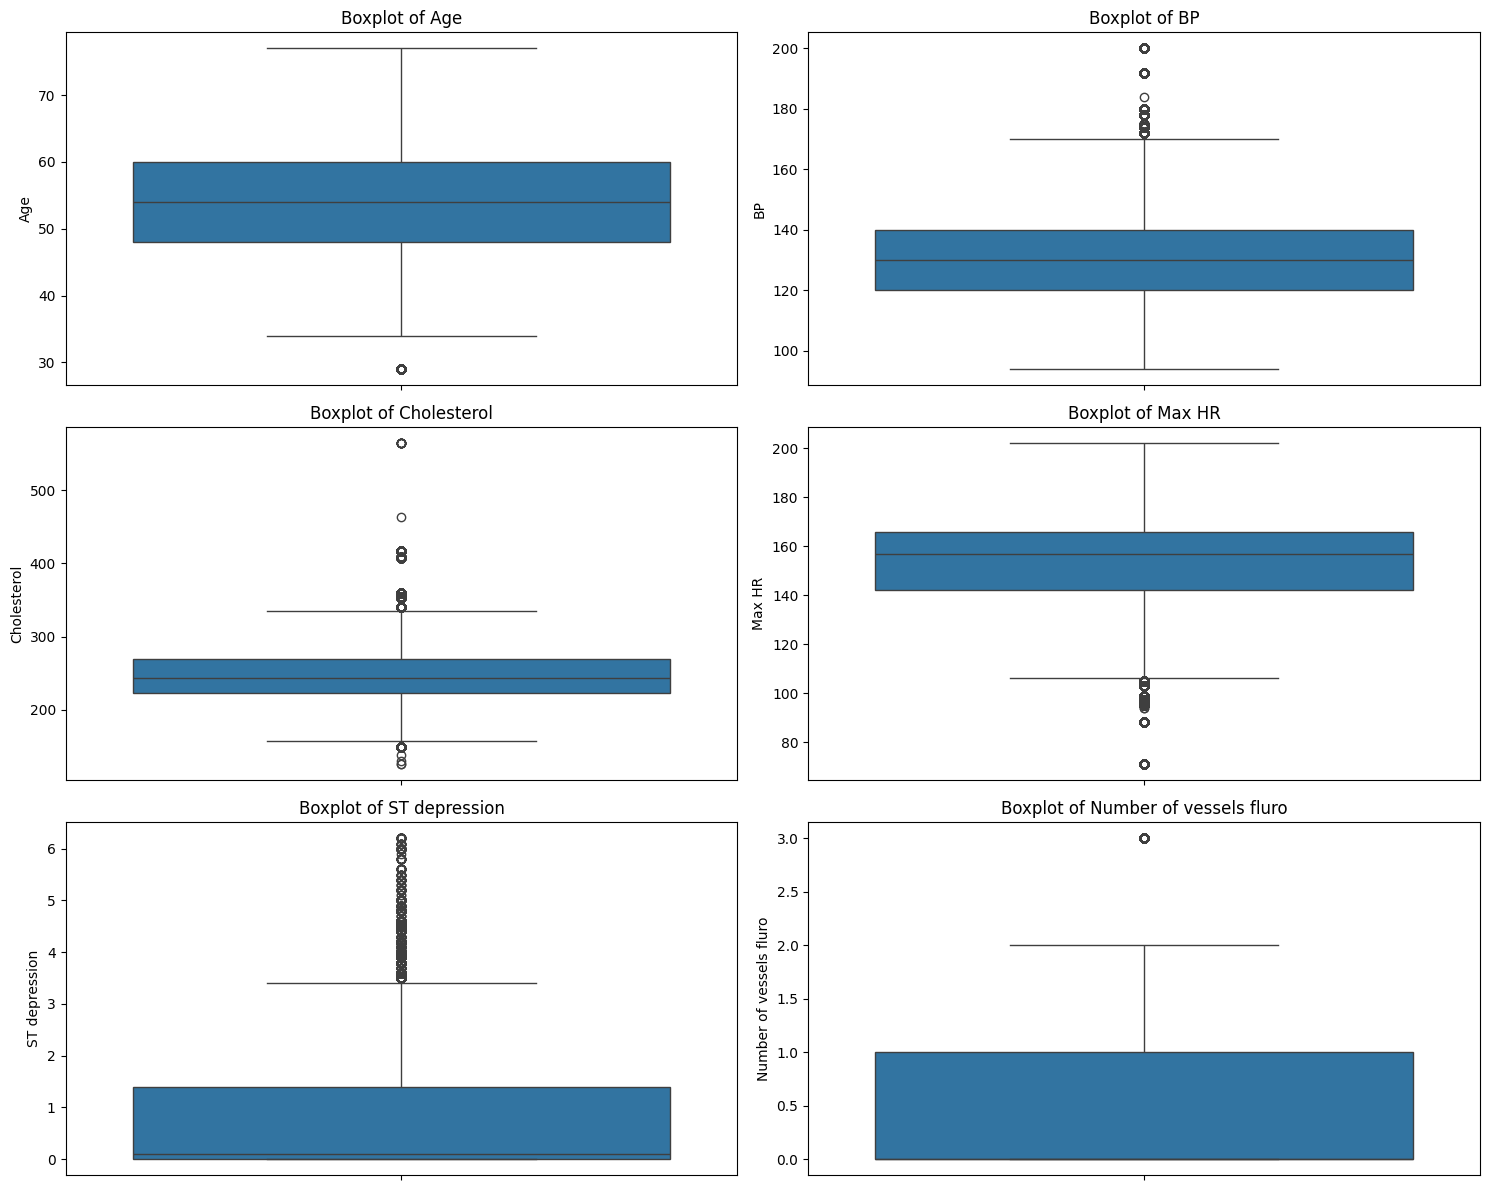

In [18]:
numerical_cols = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression', 
                  'Number of vessels fluro']

# Distribution plots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx//2, idx%2]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
plt.tight_layout()

# Box plots to detect outliers
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx//2, idx%2]
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
plt.tight_layout()

# Statistical summary
df[numerical_cols].describe()

# Check for outliers (IQR method)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")


Sex:
Sex
1    450283
0    179717
Name: count, dtype: int64
Sex
1    71.473492
0    28.526508
Name: proportion, dtype: float64

Chest pain type:
Chest pain type
4    329179
3    197278
2     74941
1     28602
Name: count, dtype: int64
Chest pain type
4    52.250635
3    31.313968
2    11.895397
1     4.540000
Name: proportion, dtype: float64

FBS over 120:
FBS over 120
0    579608
1     50392
Name: count, dtype: int64
FBS over 120
0    92.00127
1     7.99873
Name: proportion, dtype: float64

EKG results:
EKG results
0    320116
2    308562
1      1322
Name: count, dtype: int64
EKG results
0    50.812063
2    48.978095
1     0.209841
Name: proportion, dtype: float64

Exercise angina:
Exercise angina
0    457553
1    172447
Name: count, dtype: int64
Exercise angina
0    72.62746
1    27.37254
Name: proportion, dtype: float64

Slope of ST:
Slope of ST
1    358293
2    256215
3     15492
Name: count, dtype: int64
Slope of ST
1    56.871905
2    40.669048
3     2.459048
Name: proportion, dt

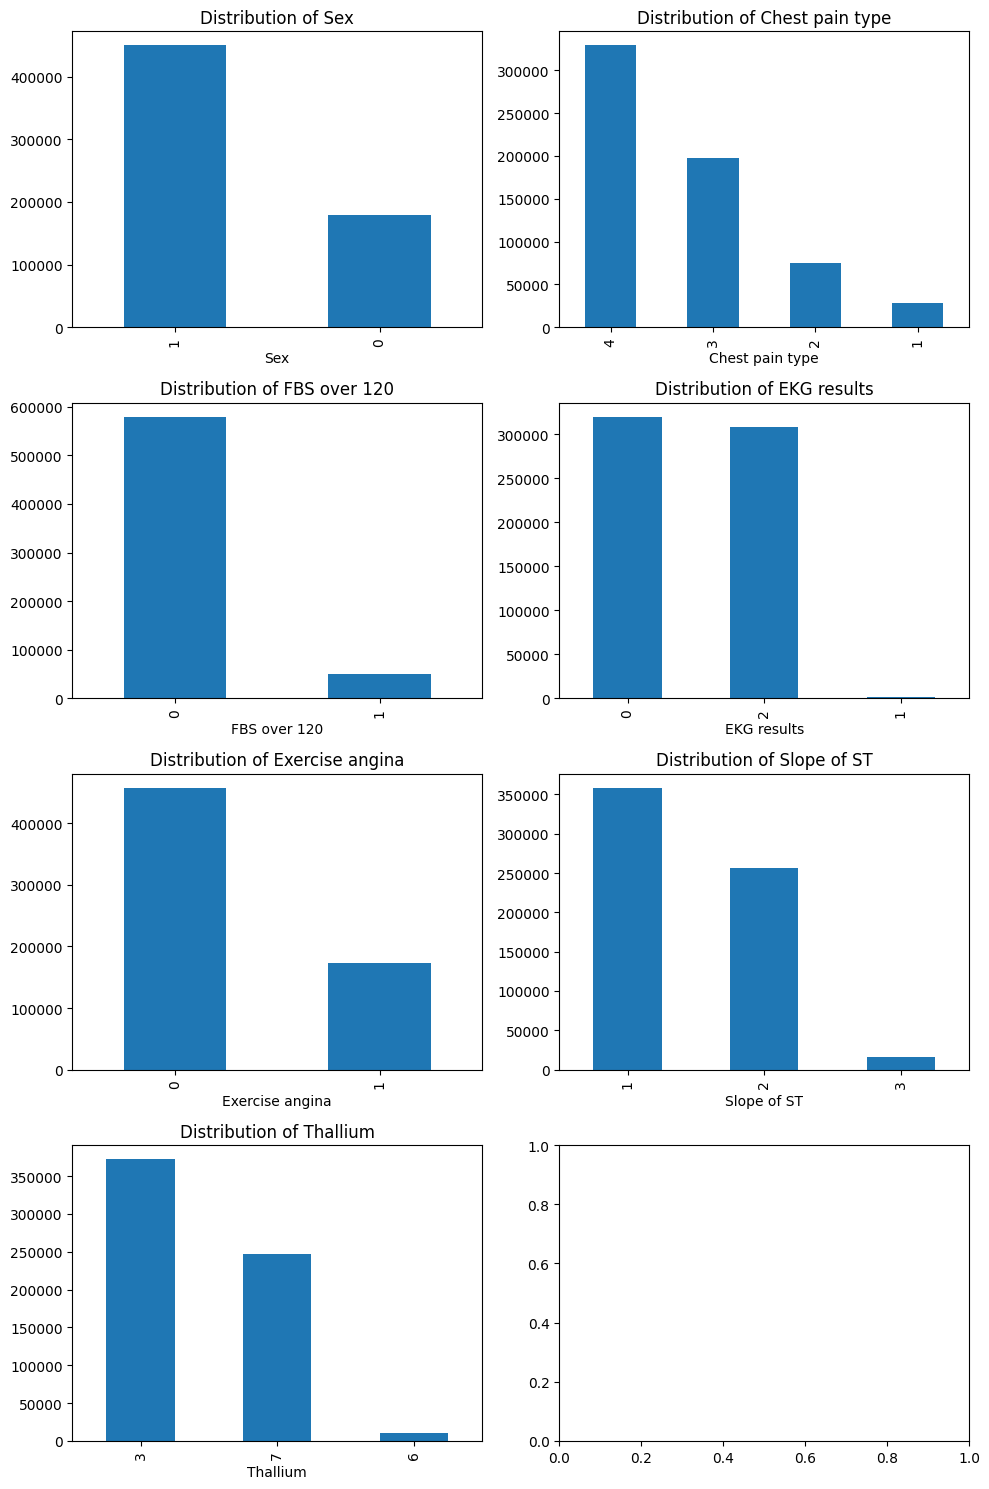

In [19]:
categorical_cols = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results', 
                    'Exercise angina', 'Slope of ST', 'Thallium']

# Value counts for each categorical variable
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(df[col].value_counts(normalize=True) * 100)

# Bar plots
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
for idx, col in enumerate(categorical_cols):
    ax = axes[idx//2, idx%2]
    df[col].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
plt.tight_layout()

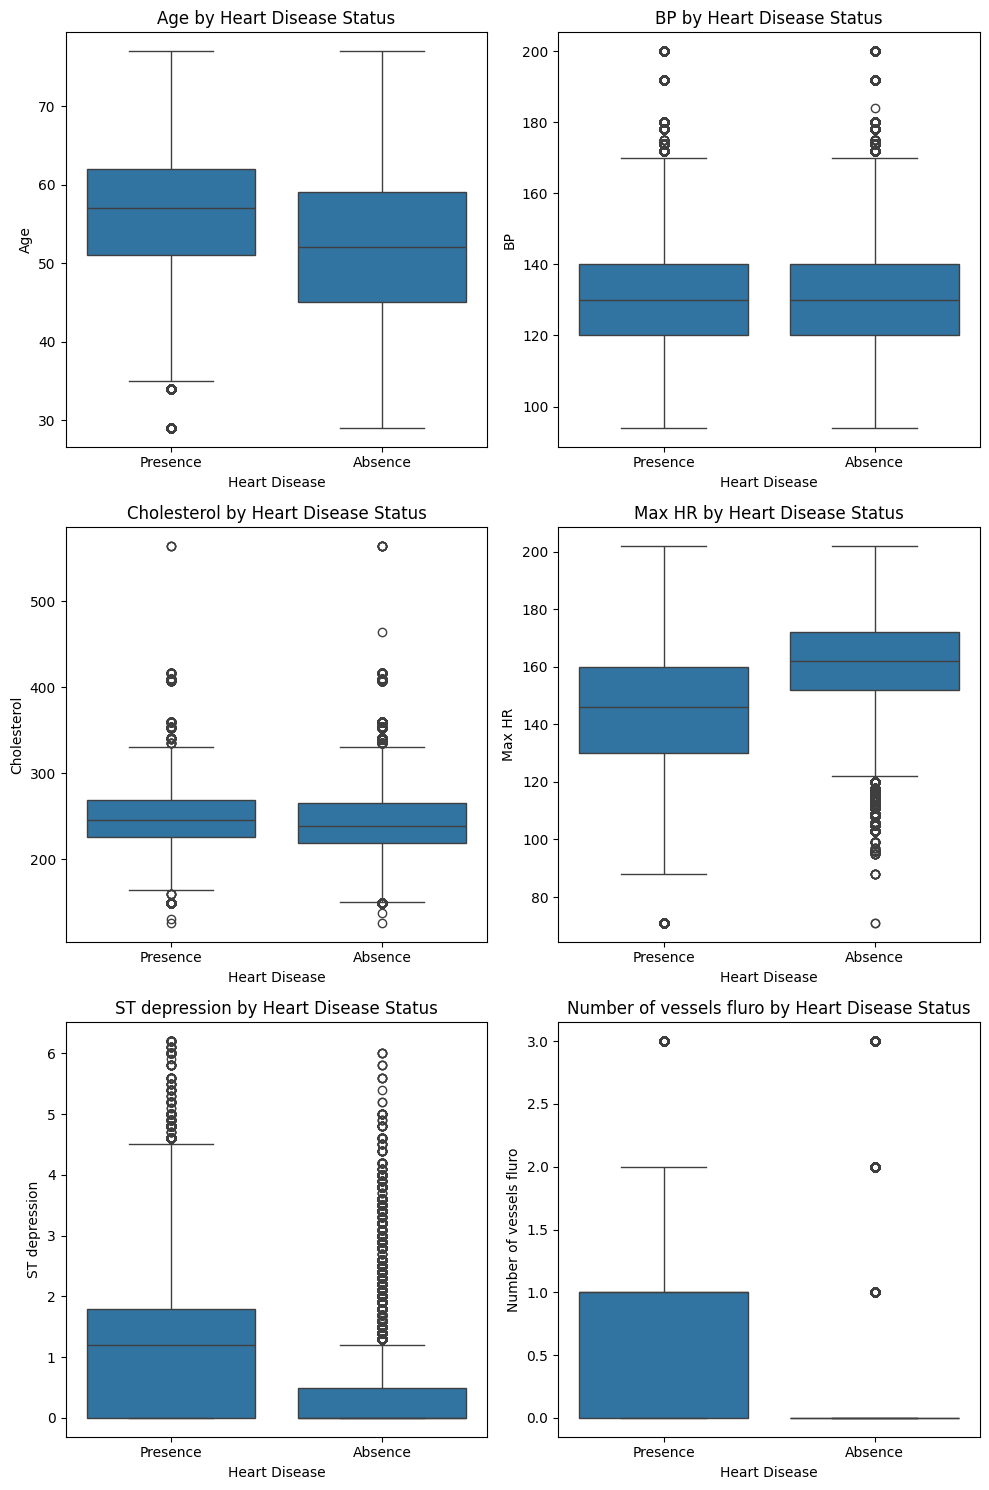

In [20]:
# Numerical features vs Target
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx//2, idx%2]
    sns.boxplot(data=df, x='Heart Disease', y=col, ax=ax)
    ax.set_title(f'{col} by Heart Disease Status')
plt.tight_layout()


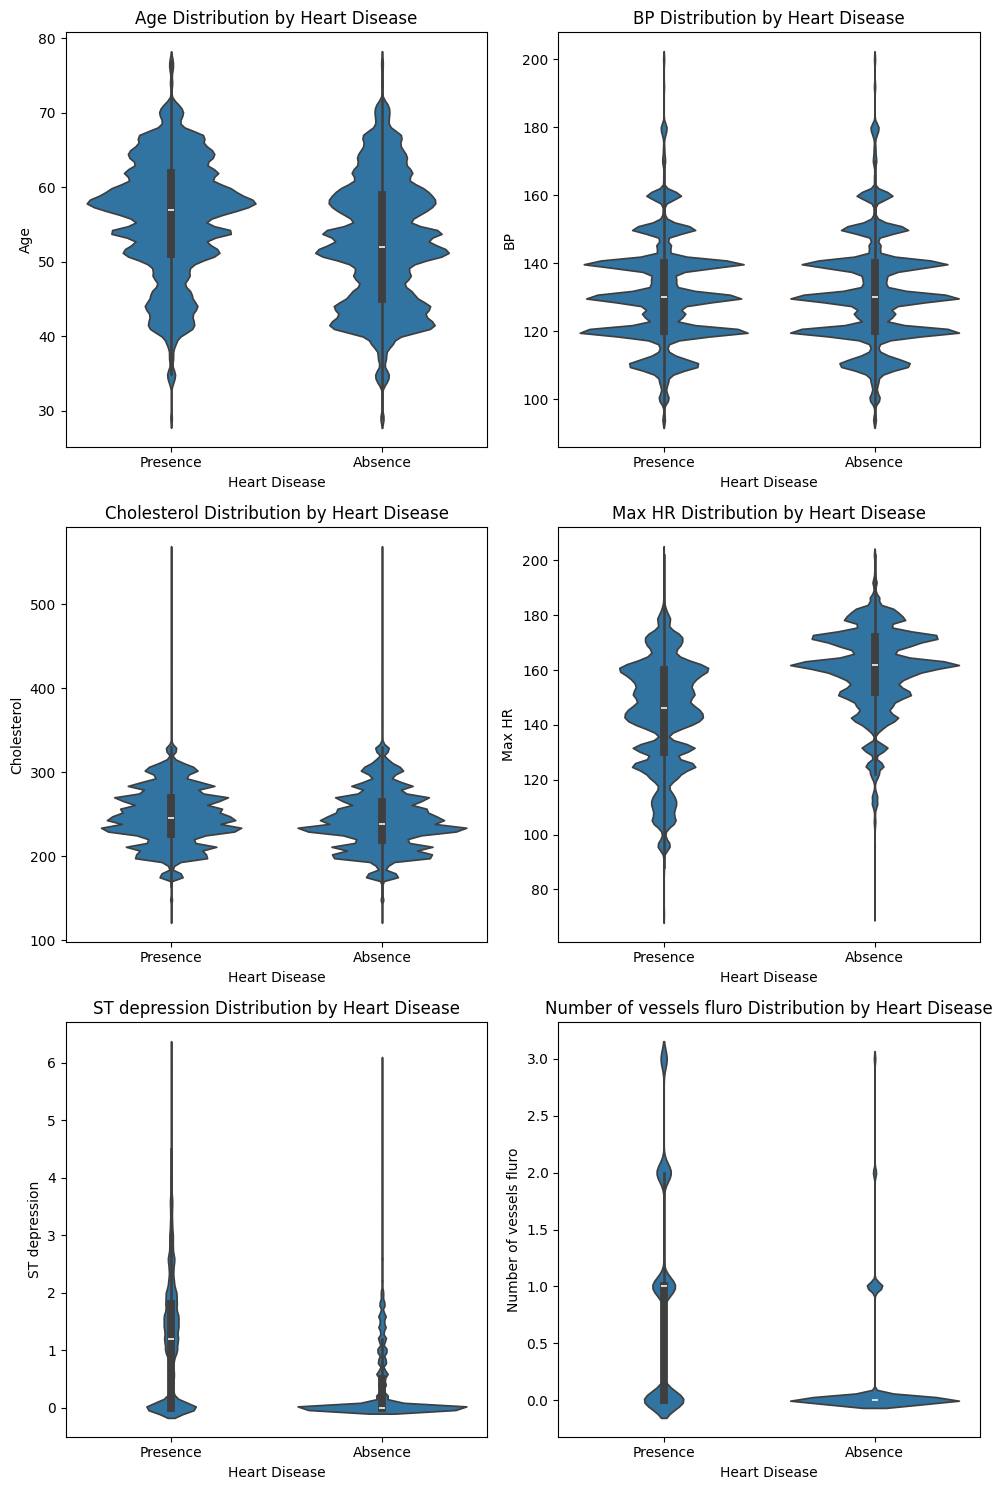

In [21]:
# Violin plots (shows distribution better)
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
for idx, col in enumerate(numerical_cols):
    ax = axes[idx//2, idx%2]
    sns.violinplot(data=df, x='Heart Disease', y=col, ax=ax)
    ax.set_title(f'{col} Distribution by Heart Disease')
plt.tight_layout()

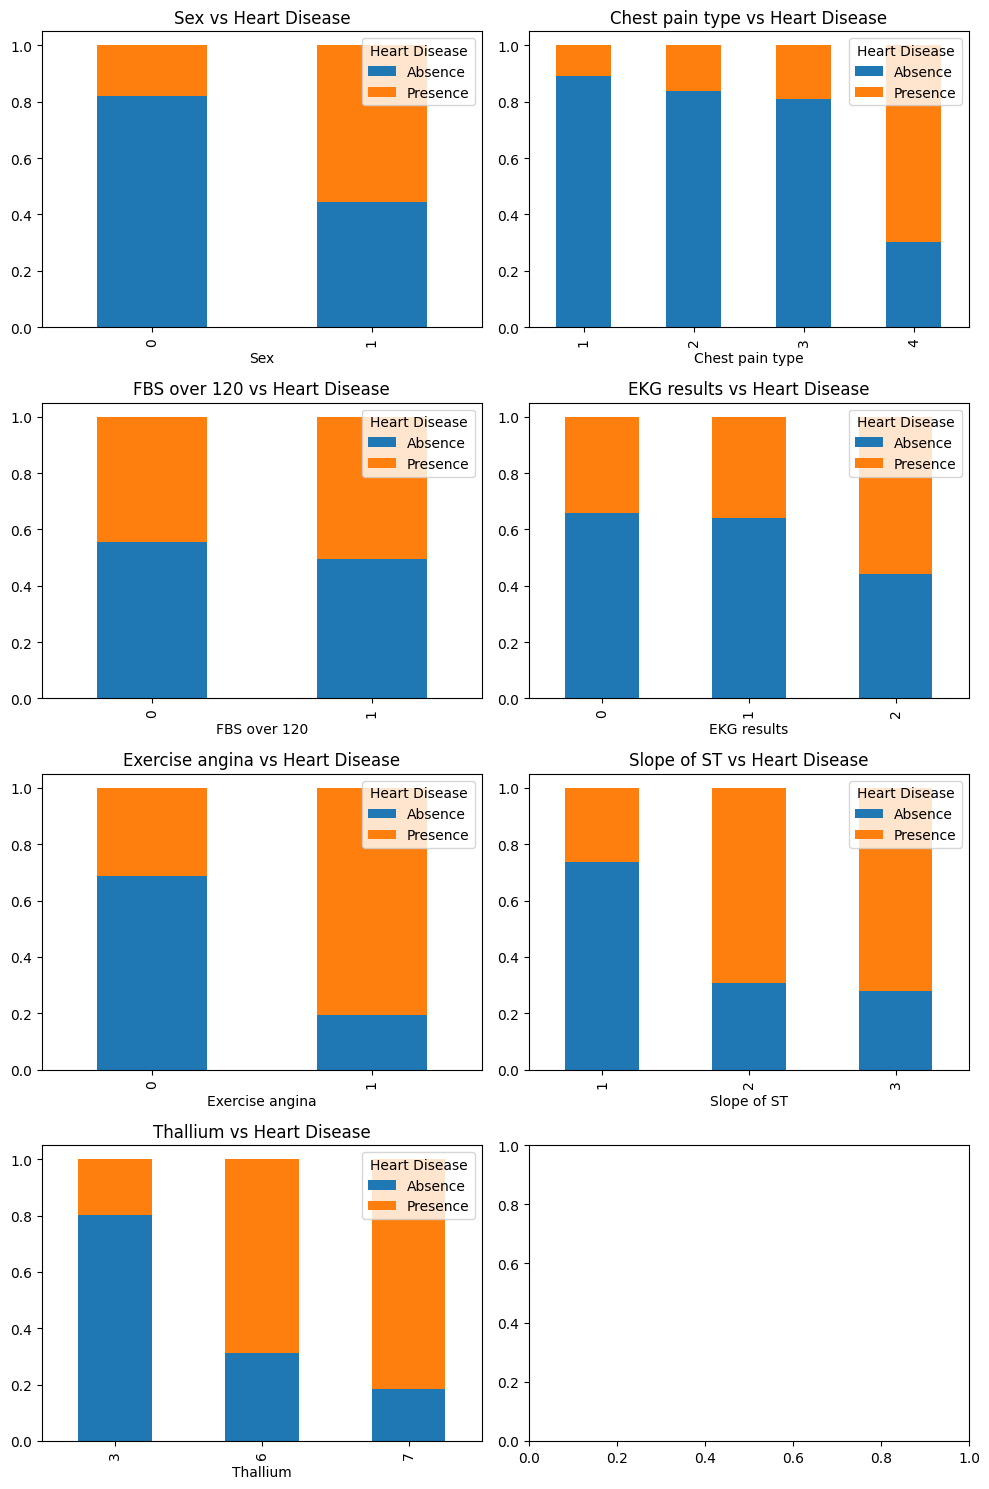

In [22]:
# Categorical features vs Target
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
for idx, col in enumerate(categorical_cols):
    ax = axes[idx//2, idx%2]
    pd.crosstab(df[col], df['Heart Disease'], normalize='index').plot(
        kind='bar', stacked=True, ax=ax)
    ax.set_title(f'{col} vs Heart Disease')
    ax.legend(title='Heart Disease')
plt.tight_layout()

In [23]:

# Statistical tests for numerical features
from scipy.stats import ttest_ind

for col in numerical_cols:
    presence = df[df['Heart Disease'] == 'Presence'][col]
    absence = df[df['Heart Disease'] == 'Absence'][col]
    stat, p_value = ttest_ind(presence, absence, nan_policy='omit')
    print(f"{col}: p-value = {p_value:.4f} {'(Significant)' if p_value < 0.05 else '(Not significant)'}")

Age: p-value = 0.0000 (Significant)
BP: p-value = 0.0000 (Significant)
Cholesterol: p-value = 0.0000 (Significant)
Max HR: p-value = 0.0000 (Significant)
ST depression: p-value = 0.0000 (Significant)
Number of vessels fluro: p-value = 0.0000 (Significant)



Correlation with Heart Disease:
Heart Disease              1.000000
Thallium                   0.603969
Chest pain type            0.460684
Exercise angina            0.441864
Number of vessels fluro    0.438604
ST depression              0.430641
Slope of ST                0.415050
Sex                        0.342446
EKG results                0.218961
Age                        0.212091
Cholesterol                0.082753
FBS over 120               0.033570
BP                        -0.005181
Max HR                    -0.440985
Name: Heart Disease, dtype: float64


Text(0.5, 0, 'Correlation Coefficient')

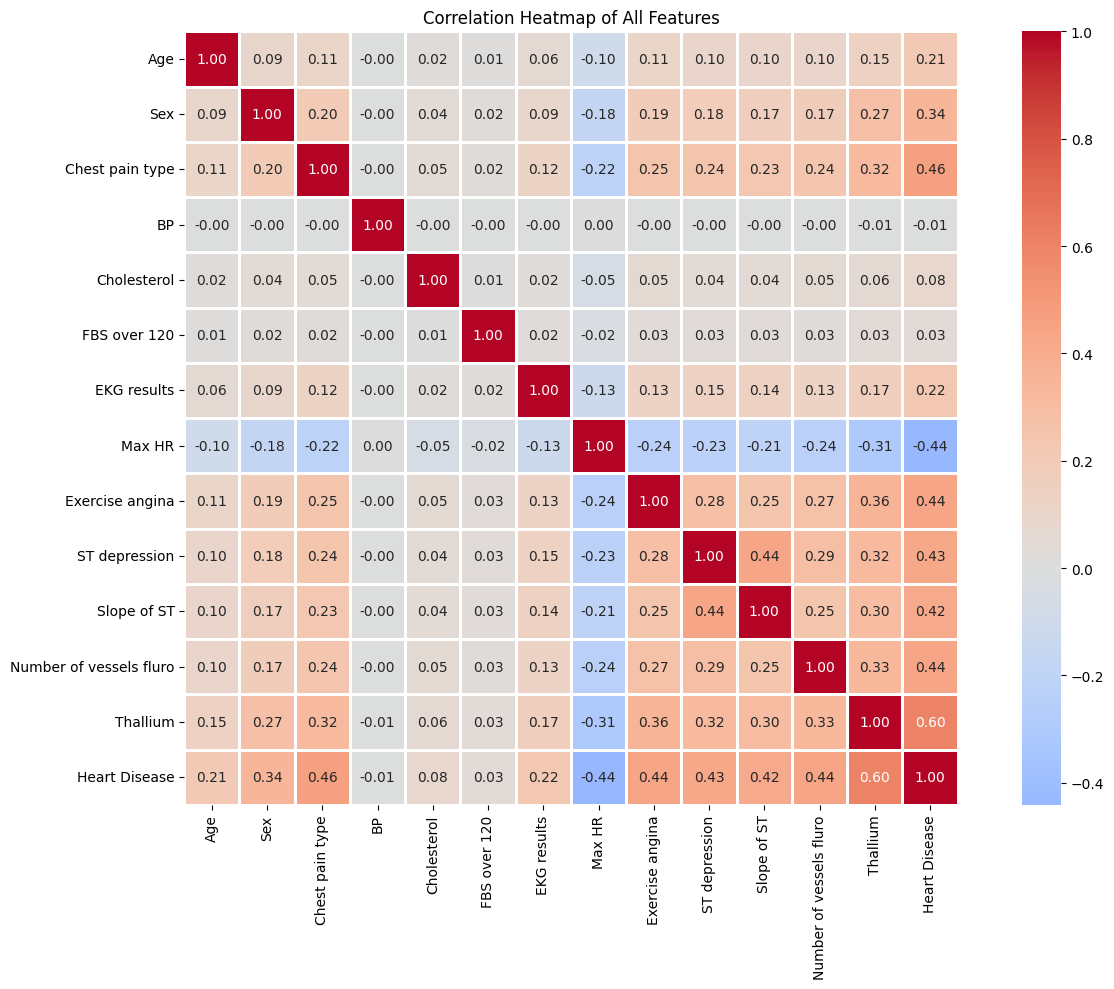

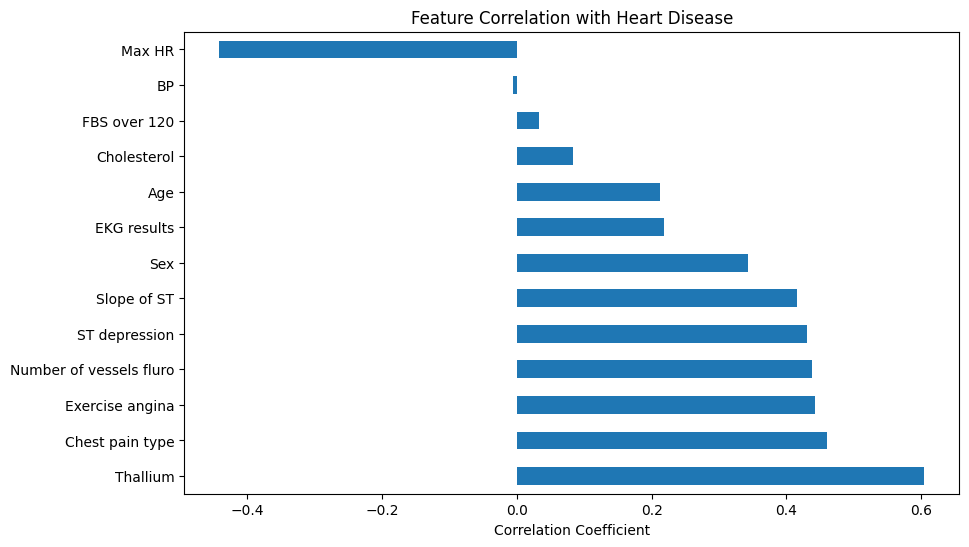

In [24]:
# Encode categorical variables for correlation
df_encoded = df.copy()

le = LabelEncoder()

for col in categorical_cols + ['Heart Disease']:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df_encoded.drop('id', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap of All Features')
plt.tight_layout()

# Correlation with target specifically
target_corr = correlation_matrix['Heart Disease'].sort_values(ascending=False)
print("\nCorrelation with Heart Disease:")
print(target_corr)

# Visualize top correlations
plt.figure(figsize=(10, 6))
target_corr[1:].plot(kind='barh')  # Exclude self-correlation
plt.title('Feature Correlation with Heart Disease')
plt.xlabel('Correlation Coefficient')

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='BP', ylabel='Age'>,
        <Axes: xlabel='Cholesterol', ylabel='Age'>,
        <Axes: xlabel='Max HR', ylabel='Age'>,
        <Axes: xlabel='ST depression', ylabel='Age'>,
        <Axes: xlabel='Number of vessels fluro', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='BP'>,
        <Axes: xlabel='BP', ylabel='BP'>,
        <Axes: xlabel='Cholesterol', ylabel='BP'>,
        <Axes: xlabel='Max HR', ylabel='BP'>,
        <Axes: xlabel='ST depression', ylabel='BP'>,
        <Axes: xlabel='Number of vessels fluro', ylabel='BP'>],
       [<Axes: xlabel='Age', ylabel='Cholesterol'>,
        <Axes: xlabel='BP', ylabel='Cholesterol'>,
        <Axes: xlabel='Cholesterol', ylabel='Cholesterol'>,
        <Axes: xlabel='Max HR', ylabel='Cholesterol'>,
        <Axes: xlabel='ST depression', ylabel='Cholesterol'>,
        <Axes: xlabel='Number of vessels fluro', ylabel='Cholesterol'>],
       [<Axes: xlabel='Age', ylabel='Max HR

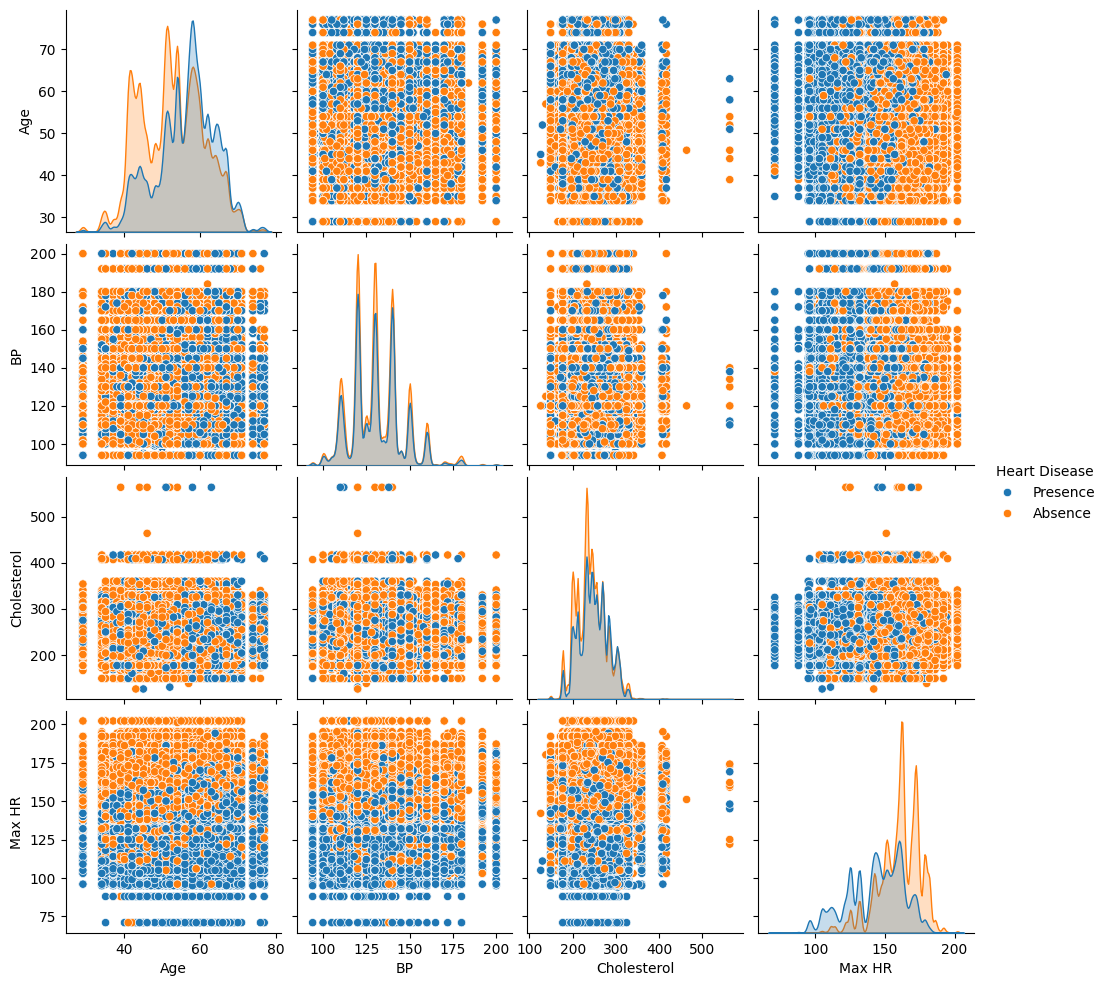

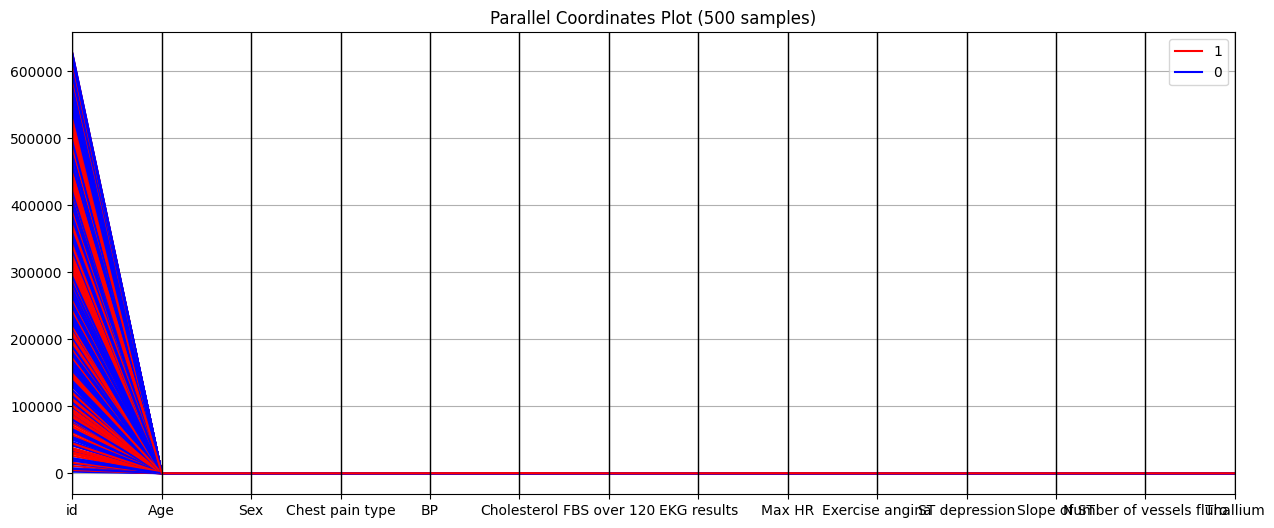

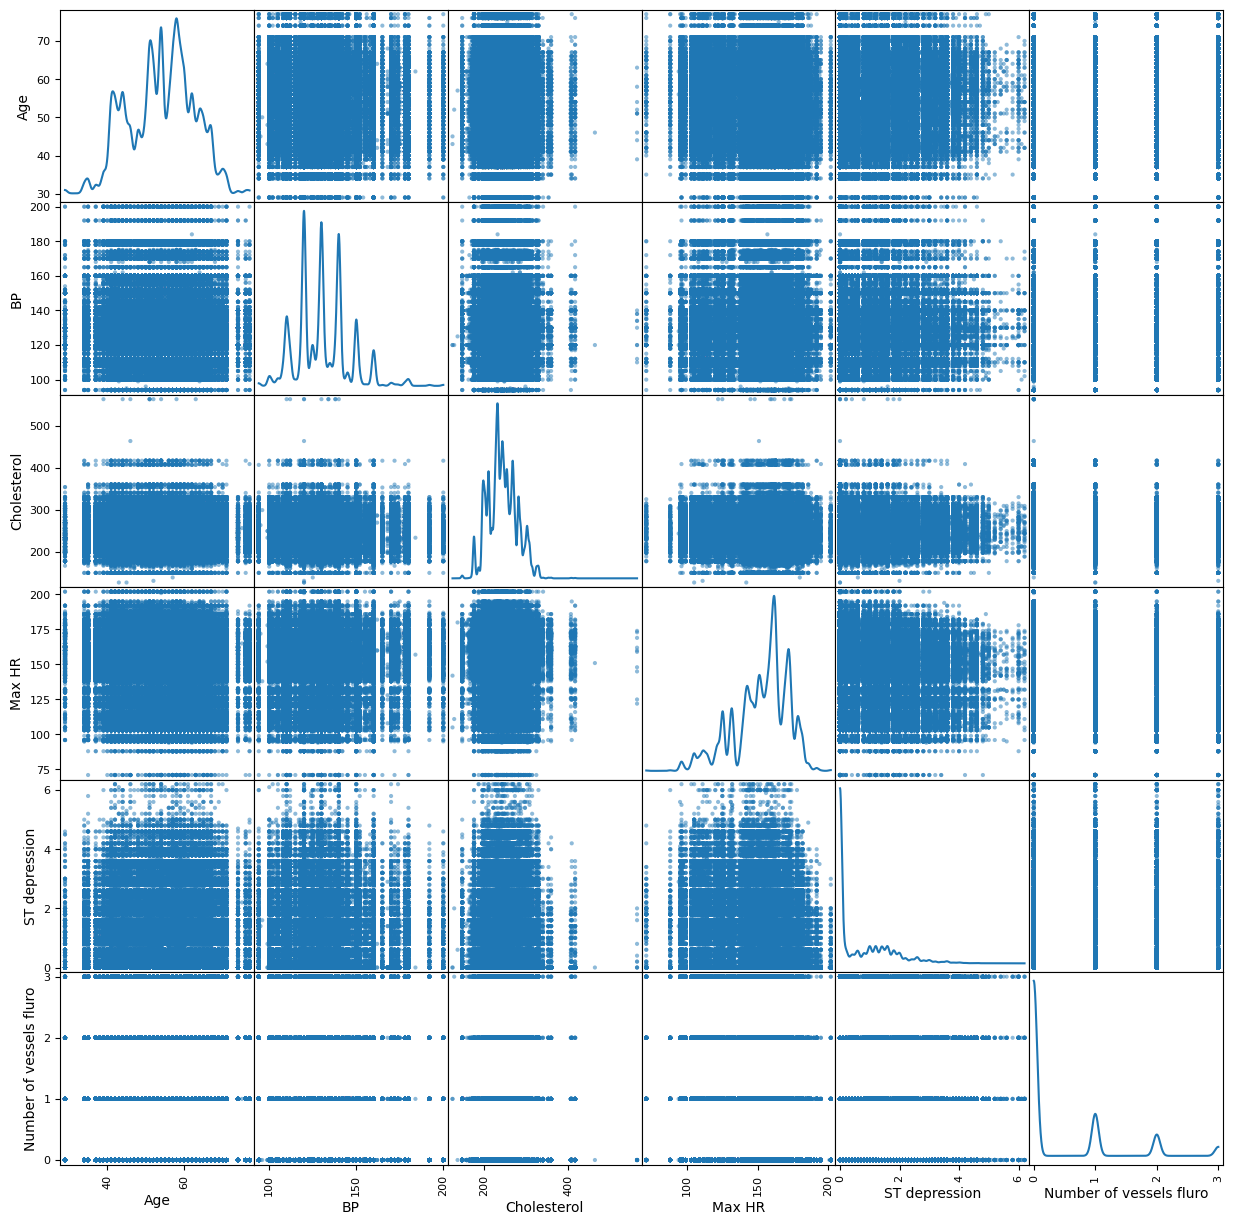

In [25]:
# Pairplot for key numerical features
key_features = ['Age', 'BP', 'Cholesterol', 'Max HR', 'Heart Disease']
sns.pairplot(df[key_features], hue='Heart Disease', diag_kind='kde')

# Advanced: Parallel coordinates plot
from pandas.plotting import parallel_coordinates
plt.figure(figsize=(15, 6))
parallel_coordinates(df_encoded.sample(500), 'Heart Disease', 
                     color=['red', 'blue'])
plt.title('Parallel Coordinates Plot (500 samples)')

# Scatter matrix for continuous variables
from pandas.plotting import scatter_matrix
scatter_matrix(df[numerical_cols + ['Heart Disease']], 
               figsize=(15, 15), diagonal='kde')

Text(0.5, 1.0, 'Age Distribution by Heart Disease Status')

<Figure size 1000x600 with 0 Axes>

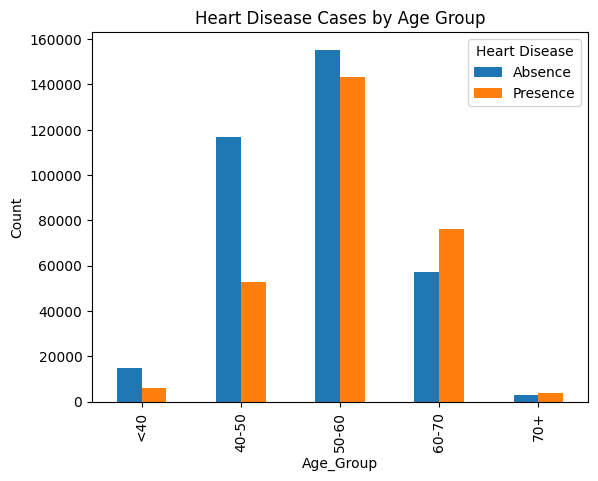

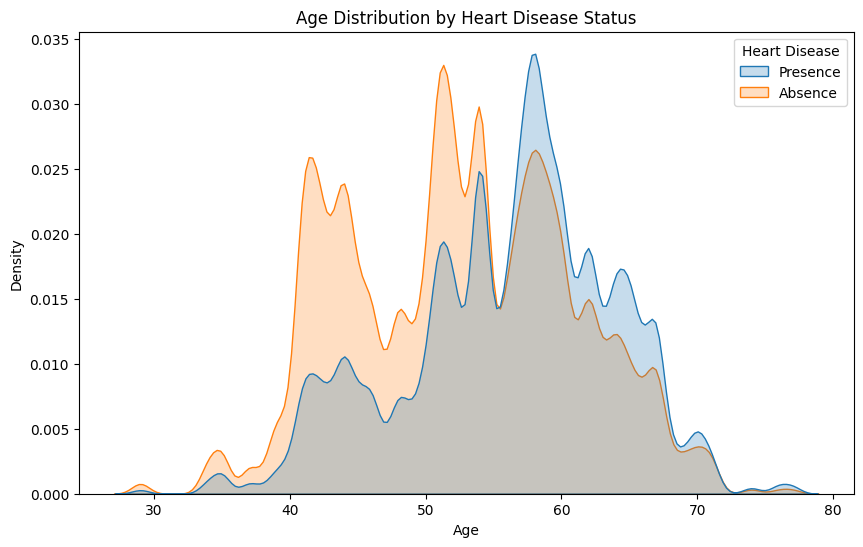

In [26]:
# Age groups analysis
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 40, 50, 60, 70, 100], 
                         labels=['<40', '40-50', '50-60', '60-70', '70+'])

# Heart disease by age group
pd.crosstab(df['Age_Group'], df['Heart Disease'], normalize='index') * 100

plt.figure(figsize=(10, 6))
pd.crosstab(df['Age_Group'], df['Heart Disease']).plot(kind='bar')
plt.title('Heart Disease Cases by Age Group')
plt.ylabel('Count')
plt.legend(title='Heart Disease')

# Age distribution by disease status
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='Age', hue='Heart Disease', fill=True)
plt.title('Age Distribution by Heart Disease Status')

Text(0, 0.5, 'Proportion')

<Figure size 1000x600 with 0 Axes>

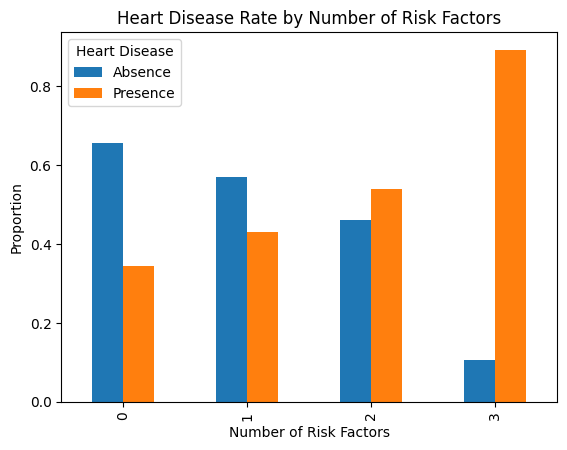

In [27]:
# High-risk combinations
df['High_BP'] = df['BP'] > 140
df['High_Cholesterol'] = df['Cholesterol'] > 200
df['Low_MaxHR'] = df['Max HR'] < 120

# Count risk factors
df['Risk_Count'] = (df['High_BP'].astype(int) + 
                    df['High_Cholesterol'].astype(int) + 
                    df['Low_MaxHR'].astype(int))

plt.figure(figsize=(10, 6))
pd.crosstab(df['Risk_Count'], df['Heart Disease'], normalize='index').plot(kind='bar')
plt.title('Heart Disease Rate by Number of Risk Factors')
plt.xlabel('Number of Risk Factors')
plt.ylabel('Proportion')

In [28]:
# Check for zero or negative values where they shouldn't exist
for col in ['BP', 'Cholesterol', 'Max HR', 'Age']:
    zero_count = (df[col] == 0).sum()
    negative_count = (df[col] < 0).sum()
    print(f"{col}: {zero_count} zeros, {negative_count} negative values")

# Check for unrealistic values
print("\nAge range:", df['Age'].min(), "-", df['Age'].max())
print("BP range:", df['BP'].min(), "-", df['BP'].max())
print("Cholesterol range:", df['Cholesterol'].min(), "-", df['Cholesterol'].max())
print("Max HR range:", df['Max HR'].min(), "-", df['Max HR'].max())

BP: 0 zeros, 0 negative values
Cholesterol: 0 zeros, 0 negative values
Max HR: 0 zeros, 0 negative values
Age: 0 zeros, 0 negative values

Age range: 29 - 77
BP range: 94 - 200
Cholesterol range: 126 - 564
Max HR range: 71 - 202


# Data Splits

In [29]:
X_train = df.drop(columns=['id', 'Heart Disease'], axis =1)
y_train = df['Heart Disease'].map({'Absence': 0, 'Presence': 1})
print(X_train.shape)
print(y_train.shape)

(630000, 18)
(630000,)


In [30]:
X_train.head(5)

Age  Sex  Chest pain type   BP  Cholesterol  FBS over 120  EKG results  \
0   58    1                4  152          239             0            0   
1   52    1                1  125          325             0            2   
2   56    0                2  160          188             0            2   
3   44    0                3  134          229             0            2   
4   58    1                4  140          234             0            2   

   Max HR  Exercise angina  ST depression  Slope of ST  \
0     158                1            3.6            2   
1     171                0            0.0            1   
2     151                0            0.0            1   
3     150                0            1.0            2   
4     125                1            3.8            2   

   Number of vessels fluro  Thallium Age_Group  High_BP  High_Cholesterol  \
0                        2         7     50-60     True              True   
1                        0         3     50-60    False              True   
2                        0         3     50-60     True             False   
3                        0         3     40-50    False              True   
4                        3         3     50-60    False              True   

   Low_MaxHR  Risk_Count  
0      False           2  
1      False           1  
2      False           1  
3      False           1  
4      False           1

In [31]:
X_test = test_df.drop(columns=['id'],axis =1)

In [32]:
X_test.shape

(270000, 13)

# Feature Engineering

In [33]:
def engineer_features(df):
    """
    Comprehensive feature engineering for heart disease prediction.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe with original features
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with engineered features added
    """
    
    df = df.copy()
    
    print("="*80)
    print("FEATURE ENGINEERING")
    print("="*80)
    
    # -------------------------------------------------------------------------
    # BINARY FEATURES (Based on Medical Thresholds & EDA Insights)
    # -------------------------------------------------------------------------
    print("\n[1/9] Creating binary features...")
    
    # Age-based
    df['Age_Over_50'] = (df['Age'] >= 50).astype(int)
    df['Age_Over_60'] = (df['Age'] >= 60).astype(int)
    df['Age_Under_40'] = (df['Age'] < 40).astype(int)
    
    # Vital signs (medical thresholds)
    df['High_BP'] = (df['BP'] > 140).astype(int)
    df['Very_High_BP'] = (df['BP'] > 160).astype(int)
    df['High_Cholesterol'] = (df['Cholesterol'] > 200).astype(int)
    df['Very_High_Cholesterol'] = (df['Cholesterol'] > 240).astype(int)
    
    # Max HR based (from pairplot analysis - clear separation)
    df['Low_MaxHR'] = (df['Max HR'] < 120).astype(int)
    df['Very_Low_MaxHR'] = (df['Max HR'] < 100).astype(int)
    df['High_MaxHR'] = (df['Max HR'] > 160).astype(int)
    
    # ST Depression (parallel plot showed healthy = 0)
    df['ST_Present'] = (df['ST depression'] > 0).astype(int)
    df['ST_Elevated'] = (df['ST depression'] > 1).astype(int)
    df['ST_Severe'] = (df['ST depression'] > 2).astype(int)
    
    # Number of vessels (perfect separation at 0 in parallel plot)
    df['Any_Vessel_Blockage'] = (df['Number of vessels fluro'] > 0).astype(int)
    df['Multiple_Vessel_Blockage'] = (df['Number of vessels fluro'] > 1).astype(int)
    
    # Categorical recodings
    df['Male'] = (df['Sex'] == 1).astype(int)
    df['Severe_Chest_Pain'] = (df['Chest pain type'] == 4).astype(int)
    df['Abnormal_EKG'] = (df['EKG results'] == 2).astype(int)
    df['Thallium_Abnormal'] = (df['Thallium'] != 3).astype(int)
    df['Thallium_Reversible'] = (df['Thallium'] == 7).astype(int)
    
    print(f"   ✓ Created 20 binary features")
    
    # -------------------------------------------------------------------------
    # AGE GROUP BINNING (Based on density plot - bimodal distribution)
    # -------------------------------------------------------------------------
    print("[2/9] Creating age group features...")
    
    df['Age_Group_4'] = pd.cut(df['Age'], 
                               bins=[0, 40, 50, 60, 100], 
                               labels=[0, 1, 2, 3]).astype(int)
    
    df['Age_Group_5'] = pd.cut(df['Age'], 
                               bins=[0, 40, 45, 50, 60, 100], 
                               labels=[0, 1, 2, 3, 4]).astype(int)
    
    df['Age_Bin_10yr'] = (df['Age'] // 10).astype(int)
    
    print(f"   ✓ Created 3 age group features")
    
    # -------------------------------------------------------------------------
    # BINNING FOR ROUNDED MEASUREMENTS (Pairplot showed banding)
    # -------------------------------------------------------------------------
    print("[3/9] Binning measurements with rounding artifacts...")
    
    # BP bins (horizontal banding at 110, 120, 130, 140...)
    df['BP_Bin'] = pd.cut(df['BP'], 
                          bins=[0, 120, 140, 160, 300], 
                          labels=[0, 1, 2, 3]).astype(int)
    
    # Cholesterol bins
    df['Cholesterol_Bin'] = pd.cut(df['Cholesterol'], 
                                   bins=[0, 200, 240, 280, 600], 
                                   labels=[0, 1, 2, 3]).astype(int)
    
    # Max HR bins (bimodal pattern)
    df['MaxHR_Bin'] = pd.cut(df['Max HR'], 
                             bins=[0, 100, 130, 150, 170, 220], 
                             labels=[0, 1, 2, 3, 4]).astype(int)
    
    # ST Depression bins
    df['ST_Bin'] = pd.cut(df['ST depression'], 
                          bins=[-np.inf, 0, 1, 2, np.inf], 
                          labels=[0, 1, 2, 3]).astype(int)
    
    print(f"   ✓ Created 4 binned features")
    
    # -------------------------------------------------------------------------
    # POLYNOMIAL FEATURES (Non-linear relationships)
    # -------------------------------------------------------------------------
    print("[4/9] Creating polynomial features...")
    
    df['Age_Squared'] = df['Age'] ** 2
    df['BP_Squared'] = df['BP'] ** 2
    df['ST_Squared'] = df['ST depression'] ** 2
    
    print(f"   ✓ Created 3 polynomial features")
    
    # -------------------------------------------------------------------------
    # RATIO FEATURES (Relative metrics)
    # -------------------------------------------------------------------------
    print("[5/9] Creating ratio features...")
    
    # Age-adjusted Max HR (fitness measure)
    df['MaxHR_Percent_Theoretical'] = df['Max HR'] / (220 - df['Age'] + 1)
    
    # BP to Cholesterol ratio
    df['BP_Cholesterol_Ratio'] = df['BP'] / (df['Cholesterol'] + 1)
    
    # Age to Max HR ratio
    df['Age_MaxHR_Ratio'] = df['Age'] / (df['Max HR'] + 1)
    
    # ST depression to Max HR ratio
    df['ST_MaxHR_Ratio'] = df['ST depression'] / (df['Max HR'] + 1)
    
    print(f"   ✓ Created 4 ratio features")
    
    # -------------------------------------------------------------------------
    # INTERACTION FEATURES (Multiplicative combinations)
    # -------------------------------------------------------------------------
    print("[6/9] Creating interaction features...")
    
    # Age interactions
    df['Age_BP'] = df['Age'] * df['BP'] / 100
    df['Age_Cholesterol'] = df['Age'] * df['Cholesterol'] / 100
    df['Age_MaxHR'] = df['Age'] * df['Max HR'] / 100
    df['Age_Vessels'] = df['Age'] * df['Number of vessels fluro']
    df['Age_ST'] = df['Age'] * df['ST depression']
    
    # Sex interactions
    df['Male_Age'] = df['Male'] * df['Age']
    df['Male_BP'] = df['Male'] * df['BP']
    df['Male_Cholesterol'] = df['Male'] * df['Cholesterol']
    
    # Exercise test interactions
    df['ST_MaxHR'] = df['ST depression'] * df['Max HR'] / 100
    df['Angina_MaxHR'] = df['Exercise angina'] * df['Max HR']
    df['Angina_ST'] = df['Exercise angina'] * df['ST depression']
    
    # Severity combinations
    df['Vessels_Thallium'] = df['Number of vessels fluro'] * (df['Thallium'] == 7).astype(int)
    df['Vessels_ST'] = df['Number of vessels fluro'] * df['ST depression']
    df['ChestPain_Angina'] = df['Chest pain type'] * df['Exercise angina']
    
    # Risk score
    df['Risk_Score'] = (df['High_BP'] + df['High_Cholesterol'] + 
                        df['Low_MaxHR'] + df['ST_Present'] + 
                        df['Any_Vessel_Blockage']).astype(int)
    
    print(f"   ✓ Created 15 interaction features")
    
    # -------------------------------------------------------------------------
    # TRANSFORMATIONS FOR SKEWED FEATURES
    # -------------------------------------------------------------------------
    print("[7/9] Applying transformations for skewed features...")
    
    # Log transform for right-skewed ST depression
    df['ST_Log'] = np.log1p(df['ST depression'])
    
    # Log transform for vessels
    df['Vessels_Log'] = np.log1p(df['Number of vessels fluro'])
    
    print(f"   ✓ Created 2 log-transformed features")
    
    # -------------------------------------------------------------------------
    # AGGREGATED FEATURES
    # -------------------------------------------------------------------------
    print("[8/9] Creating aggregated features...")
    
    # Cardiovascular stress index
    df['CV_Stress_Index'] = (
        df['BP'] * df['ST depression'] * df['Number of vessels fluro']
    ) / (df['Max HR'] + 1)
    
    # Overall health score
    df['Health_Score'] = (
        (df['Max HR'] - 100) / 100 +
        (200 - df['BP']) / 100 +
        (250 - df['Cholesterol']) / 100 -
        df['ST depression'] * 10 -
        df['Number of vessels fluro'] * 20
    )
    
    print(f"   ✓ Created 2 aggregated features")
    
    # -------------------------------------------------------------------------
    # ONE-HOT ENCODING (Non-ordinal categoricals)
    # -------------------------------------------------------------------------
    print("[9/9] One-hot encoding categorical features...")
    
    # Thallium is non-ordinal (3=20% disease, 6=70%, 7=82%)
    df = pd.get_dummies(df, columns=['Thallium'], prefix='Thallium', drop_first=False)
    
    n_thallium_cols = len([col for col in df.columns if col.startswith('Thallium_')])
    print(f"   ✓ Created {n_thallium_cols} one-hot encoded features")
    
    # -------------------------------------------------------------------------
    # SUMMARY
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("FEATURE ENGINEERING SUMMARY")
    print("="*80)
    
    original_count = 13  # Original features
    engineered_count = len([col for col in df.columns if col not in 
                           ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
                            'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
                            'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']])
    
    print(f"\nOriginal features: {original_count}")
    print(f"Engineered features: {engineered_count}")
    print(f"Total features: {len(df.columns)}")
    print("\n✅ Feature engineering complete!")
    print("="*80 + "\n")
    
    return df

In [34]:
X_train_eng = engineer_features(X_train)
X_test_eng = engineer_features(X_test)

FEATURE ENGINEERING

[1/9] Creating binary features...
   ✓ Created 20 binary features
[2/9] Creating age group features...
   ✓ Created 3 age group features
[3/9] Binning measurements with rounding artifacts...
   ✓ Created 4 binned features
[4/9] Creating polynomial features...
   ✓ Created 3 polynomial features
[5/9] Creating ratio features...
   ✓ Created 4 ratio features
[6/9] Creating interaction features...
   ✓ Created 15 interaction features
[7/9] Applying transformations for skewed features...
   ✓ Created 2 log-transformed features
[8/9] Creating aggregated features...
   ✓ Created 2 aggregated features
[9/9] One-hot encoding categorical features...
   ✓ Created 5 one-hot encoded features

FEATURE ENGINEERING SUMMARY

Original features: 13
Engineered features: 58
Total features: 70

✅ Feature engineering complete!

FEATURE ENGINEERING

[1/9] Creating binary features...
   ✓ Created 20 binary features
[2/9] Creating age group features...
   ✓ Created 3 age group features
[3/9

# Pre Processing

In [40]:
def preprocess_data(X_train, X_test=None, scale_features=False):
    """
    Preprocess features for modeling with proper column alignment.
    """
    
    print("="*80)
    print("PREPROCESSING")
    print("="*80)
    
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy() if X_test is not None else None
    
    # -------------------------------------------------------------------------
    # CRITICAL FIX: Align columns between train and test
    # -------------------------------------------------------------------------
    if X_test_processed is not None:
        # Get columns that exist in both
        common_cols = X_train_processed.columns.intersection(X_test_processed.columns)
        
        # Check for mismatches
        train_only = set(X_train_processed.columns) - set(X_test_processed.columns)
        test_only = set(X_test_processed.columns) - set(X_train_processed.columns)
        
        if train_only or test_only:
            print("\n⚠️  Column mismatch detected!")
            if train_only:
                print(f"   Columns only in train: {train_only}")
            if test_only:
                print(f"   Columns only in test: {test_only}")
            
            print(f"\n   → Using {len(common_cols)} common columns")
            X_train_processed = X_train_processed[common_cols]
            X_test_processed = X_test_processed[common_cols]
        else:
            print("\n✓ Train and test have matching columns")
    
    # -------------------------------------------------------------------------
    # Handle any remaining missing values (safety check)
    # -------------------------------------------------------------------------
    print("\n[1/4] Checking for missing values...")
    
    train_nulls = X_train_processed.isnull().sum().sum()
    
    if train_nulls > 0:
        print(f"   ⚠ Found {train_nulls} missing values in training set")
        print("   → Filling with median...")
        X_train_processed = X_train_processed.fillna(X_train_processed.median(numeric_only=True))
    else:
        print("   ✓ No missing values in training set")
    
    if X_test_processed is not None:
        test_nulls = X_test_processed.isnull().sum().sum()
        if test_nulls > 0:
            print(f"   ⚠ Found {test_nulls} missing values in test set")
            print("   → Filling with training median...")
            # Use train medians for test set
            for col in X_test_processed.columns:
                if X_test_processed[col].isnull().any():
                    X_test_processed[col].fillna(X_train_processed[col].median(), inplace=True)
        else:
            print("   ✓ No missing values in test set")
    
    # -------------------------------------------------------------------------
    # Handle infinite values (from ratio/division operations)
    # -------------------------------------------------------------------------
    print("\n[2/4] Checking for infinite values...")
    
    train_inf = np.isinf(X_train_processed.select_dtypes(include=[np.number])).sum().sum()
    
    if train_inf > 0:
        print(f"   ⚠ Found {train_inf} infinite values in training set")
        print("   → Replacing with median...")
        X_train_processed = X_train_processed.replace([np.inf, -np.inf], np.nan)
        X_train_processed = X_train_processed.fillna(X_train_processed.median(numeric_only=True))
    else:
        print("   ✓ No infinite values in training set")
    
    if X_test_processed is not None:
        test_inf = np.isinf(X_test_processed.select_dtypes(include=[np.number])).sum().sum()
        if test_inf > 0:
            print(f"   ⚠ Found {test_inf} infinite values in test set")
            print("   → Replacing with training median...")
            X_test_processed = X_test_processed.replace([np.inf, -np.inf], np.nan)
            # Use train medians for test set
            for col in X_test_processed.columns:
                if X_test_processed[col].isnull().any():
                    X_test_processed[col].fillna(X_train_processed[col].median(), inplace=True)
        else:
            print("   ✓ No infinite values in test set")
    
    # -------------------------------------------------------------------------
    # Feature Scaling (Optional - only for linear models)
    # -------------------------------------------------------------------------
    print("\n[3/4] Feature scaling...")
    
    if scale_features:
        print("   → Applying StandardScaler...")
        
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        
        # Get numeric columns that exist in BOTH train and test
        numeric_cols = X_train_processed.select_dtypes(include=[np.number]).columns.tolist()
        
        if X_test_processed is not None:
            # Only scale columns that exist in both
            numeric_cols = [col for col in numeric_cols if col in X_test_processed.columns]
        
        # Fit on train, transform both
        X_train_processed[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])
        
        if X_test_processed is not None:
            X_test_processed[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])
        
        print(f"   ✓ Scaled {len(numeric_cols)} numeric features")
    else:
        print("   → Skipping scaling (recommended for tree-based models)")
    
    # -------------------------------------------------------------------------
    # Final Validation
    # -------------------------------------------------------------------------
    print("\n[4/4] Final validation...")
    
    # Check data types
    non_numeric = X_train_processed.select_dtypes(exclude=[np.number]).columns.tolist()
    if len(non_numeric) > 0:
        print(f"   ⚠ Warning: Non-numeric columns found: {non_numeric}")
    else:
        print("   ✓ All features are numeric")
    
    # Check shapes
    print(f"\n   Training set shape: {X_train_processed.shape}")
    if X_test_processed is not None:
        print(f"   Test set shape: {X_test_processed.shape}")
        
        # Verify same columns
        if not all(X_train_processed.columns == X_test_processed.columns):
            print("   ⚠ Warning: Train and test have different columns!")
        else:
            print("   ✓ Train and test have matching columns")
    
    # Final checks
    assert X_train_processed.isnull().sum().sum() == 0, "Missing values remain!"
    assert not np.isinf(X_train_processed.select_dtypes(include=[np.number])).any().any(), "Infinite values remain!"
    
    if X_test_processed is not None:
        assert X_test_processed.isnull().sum().sum() == 0, "Missing values remain in test!"
        assert not np.isinf(X_test_processed.select_dtypes(include=[np.number])).any().any(), "Infinite values remain in test!"
    
    print("\n" + "="*80)
    print("PREPROCESSING SUMMARY")
    print("="*80)
    print(f"\n✓ Training set: {X_train_processed.shape[0]:,} samples, {X_train_processed.shape[1]} features")
    if X_test_processed is not None:
        print(f"✓ Test set: {X_test_processed.shape[0]:,} samples, {X_test_processed.shape[1]} features")
    print("\n✅ Preprocessing complete!")
    print("="*80 + "\n")
    
    if X_test_processed is not None:
        return X_train_processed, X_test_processed
    else:
        return X_train_processed

In [41]:
X_train_final, X_test_final = preprocess_data(
    X_train_eng, 
    X_test_eng, 
    scale_features=True  # Scaling required for linear models
)

X_train_tree, X_test_tree = preprocess_data(
    X_train_eng, 
    X_test_eng, 
    scale_features=False  # No scaling needed for trees
)

PREPROCESSING

⚠️  Column mismatch detected!
   Columns only in train: {'Risk_Count', 'Age_Group'}

   → Using 68 common columns

[1/4] Checking for missing values...
   ✓ No missing values in training set
   ✓ No missing values in test set

[2/4] Checking for infinite values...
   ✓ No infinite values in training set
   ✓ No infinite values in test set

[3/4] Feature scaling...
   → Applying StandardScaler...
   ✓ Scaled 65 numeric features

[4/4] Final validation...
   ⚠ Warning: Non-numeric columns found: ['Thallium_3', 'Thallium_6', 'Thallium_7']

   Training set shape: (630000, 68)
   Test set shape: (270000, 68)
   ✓ Train and test have matching columns

PREPROCESSING SUMMARY

✓ Training set: 630,000 samples, 68 features
✓ Test set: 270,000 samples, 68 features

✅ Preprocessing complete!

PREPROCESSING

⚠️  Column mismatch detected!
   Columns only in train: {'Risk_Count', 'Age_Group'}

   → Using 68 common columns

[1/4] Checking for missing values...
   ✓ No missing values in t

# Prediction Models

In [45]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(
            penalty='l2',
            C=1.0,
            solver='lbfgs',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ),
        'X_train': X_train_final,
        'X_test': X_test_final
    },
    
    'Random Forest': {
        'model': RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1,
            verbose=0
        ),
        'X_train': X_train_tree,
        'X_test': X_test_tree
    },
    
    'XGBoost': {
        'model': xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            max_depth=6,
            learning_rate=0.05,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3,
            gamma=0.1,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            verbosity=0
        ),
        'X_train': X_train_tree,
        'X_test': X_test_tree
    },
    
    'LightGBM': {
        'model': lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            boosting_type='gbdt',
            num_leaves=31,
            learning_rate=0.05,
            n_estimators=500,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_samples=20,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'X_train': X_train_tree,
        'X_test': X_test_tree
    },
    
    'CatBoost': {
        'model': CatBoostClassifier(
            iterations=500,
            learning_rate=0.05,
            depth=6,
            l2_leaf_reg=3,
            eval_metric='AUC',
            random_seed=42,
            verbose=False
        ),
        'X_train': X_train_tree,
        'X_test': X_test_tree
    }
}

In [46]:
print(f"\n✓ Defined {len(models)} models:")
for name in models.keys():
    print(f"   • {name}")


✓ Defined 5 models:
   • Logistic Regression
   • Random Forest
   • XGBoost
   • LightGBM
   • CatBoost


In [49]:
results = {}
cv_predictions = {}
test_predictions = {}

n_splits = 5
cv = n_splits
for model_name, model_config in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")
    
    model = model_config['model']
    X_tr = model_config['X_train']
    X_te = model_config['X_test']
    
    # Cross-validation scores
    print(f"\nRunning {n_splits}-fold CV...")
    cv_scores = cross_val_score(
        model, X_tr, y_train, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1
    )
    
    # Cross-validated predictions
    print("Getting CV predictions...")
    y_cv_pred_proba = cross_val_predict(
        model, X_tr, y_train, cv=cv, method='predict_proba', n_jobs=-1
    )[:, 1]
    
    y_cv_pred = (y_cv_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    cv_roc_auc = roc_auc_score(y_train, y_cv_pred_proba)
    cv_accuracy = accuracy_score(y_train, y_cv_pred)
    cv_precision = precision_score(y_train, y_cv_pred)
    cv_recall = recall_score(y_train, y_cv_pred)
    cv_f1 = f1_score(y_train, y_cv_pred)
    
    # Store CV predictions and metrics
    cv_predictions[model_name] = y_cv_pred_proba
    
    results[model_name] = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_roc_auc': cv_roc_auc,
        'cv_accuracy': cv_accuracy,
        'cv_precision': cv_precision,
        'cv_recall': cv_recall,
        'cv_f1': cv_f1,
        'confusion_matrix': confusion_matrix(y_train, y_cv_pred)
    }
    
    # Print fold scores
    print(f"\nFold Scores:")
    for fold, score in enumerate(cv_scores, 1):
        print(f"  Fold {fold}: {score:.6f}")
    
    print(f"\n CV Metrics:")
    print(f"  ROC-AUC:   {cv_roc_auc:.6f} (±{cv_scores.std():.6f})")
    print(f"  Accuracy:  {cv_accuracy:.6f}")
    print(f"  Precision: {cv_precision:.6f}")
    print(f"  Recall:    {cv_recall:.6f}")
    print(f"  F1-Score:  {cv_f1:.6f}")
    
    # Train final model on full training data
    print(f"\nTraining final model on full dataset...")
    model.fit(X_tr, y_train)
    
    # Test predictions
    print("Generating test predictions...")
    test_pred_proba = model.predict_proba(X_te)[:, 1]
    test_predictions[model_name] = test_pred_proba
    
    print(f" {model_name} complete!")



Training: Logistic Regression

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


Getting CV predictions...

Fold Scores:
  Fold 1: 0.953736
  Fold 2: 0.952710
  Fold 3: 0.953687
  Fold 4: 0.952500
  Fold 5: 0.952865

 CV Metrics:
  ROC-AUC:   0.953100 (±0.000513)
  Accuracy:  0.885814
  Precision: 0.882420
  Recall:    0.859892
  F1-Score:  0.871011

Training final model on full dataset...
Generating test predictions...
 Logistic Regression complete!

Training: Random Forest

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.9min finished


Getting CV predictions...

Fold Scores:
  Fold 1: 0.952807
  Fold 2: 0.951810
  Fold 3: 0.952960
  Fold 4: 0.951659
  Fold 5: 0.952031

 CV Metrics:
  ROC-AUC:   0.952251 (±0.000530)
  Accuracy:  0.885076
  Precision: 0.879172
  Recall:    0.862158
  F1-Score:  0.870582

Training final model on full dataset...
Generating test predictions...
 Random Forest complete!

Training: XGBoost

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Getting CV predictions...

Fold Scores:
  Fold 1: 0.955466
  Fold 2: 0.954654
  Fold 3: 0.955570
  Fold 4: 0.954460
  Fold 5: 0.955017

 CV Metrics:
  ROC-AUC:   0.955032 (±0.000435)
  Accuracy:  0.888324
  Precision: 0.881619
  Recall:    0.867380
  F1-Score:  0.874442

Training final model on full dataset...
Generating test predictions...
 XGBoost complete!

Training: LightGBM

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.5min finished


Getting CV predictions...

Fold Scores:
  Fold 1: 0.955500
  Fold 2: 0.954688
  Fold 3: 0.955534
  Fold 4: 0.954414
  Fold 5: 0.954995

 CV Metrics:
  ROC-AUC:   0.955025 (±0.000441)
  Accuracy:  0.888367
  Precision: 0.881587
  Recall:    0.867532
  F1-Score:  0.874503

Training final model on full dataset...
Generating test predictions...
 LightGBM complete!

Training: CatBoost

Running 5-fold CV...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Getting CV predictions...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished



Fold Scores:
  Fold 1: 0.955561
  Fold 2: 0.954727
  Fold 3: 0.955692
  Fold 4: 0.954489
  Fold 5: 0.955019

 CV Metrics:
  ROC-AUC:   0.955096 (±0.000465)
  Accuracy:  0.888330
  Precision: 0.882582
  Recall:    0.866159
  F1-Score:  0.874293

Training final model on full dataset...
Generating test predictions...
 CatBoost complete!


In [52]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'ROC-AUC': [results[m]['cv_roc_auc'] for m in results.keys()],
    'Accuracy': [results[m]['cv_accuracy'] for m in results.keys()],
    'Precision': [results[m]['cv_precision'] for m in results.keys()],
    'Recall': [results[m]['cv_recall'] for m in results.keys()],
    'F1-Score': [results[m]['cv_f1'] for m in results.keys()],
    'CV Std': [results[m]['cv_std'] for m in results.keys()]
}).sort_values('ROC-AUC', ascending=False)

print("\n" + comparison_df.to_string(index=False))

# Highlight best model
best_model = comparison_df.iloc[0]['Model']
best_score = comparison_df.iloc[0]['ROC-AUC']
print(f"\n BEST MODEL: {best_model} (ROC-AUC: {best_score:.6f})")


              Model  ROC-AUC  Accuracy  Precision   Recall  F1-Score   CV Std
           CatBoost 0.955096  0.888330   0.882582 0.866159  0.874293 0.000465
            XGBoost 0.955032  0.888324   0.881619 0.867380  0.874442 0.000435
           LightGBM 0.955025  0.888367   0.881587 0.867532  0.874503 0.000441
Logistic Regression 0.953100  0.885814   0.882420 0.859892  0.871011 0.000513
      Random Forest 0.952251  0.885076   0.879172 0.862158  0.870582 0.000530

 BEST MODEL: CatBoost (ROC-AUC: 0.955096)


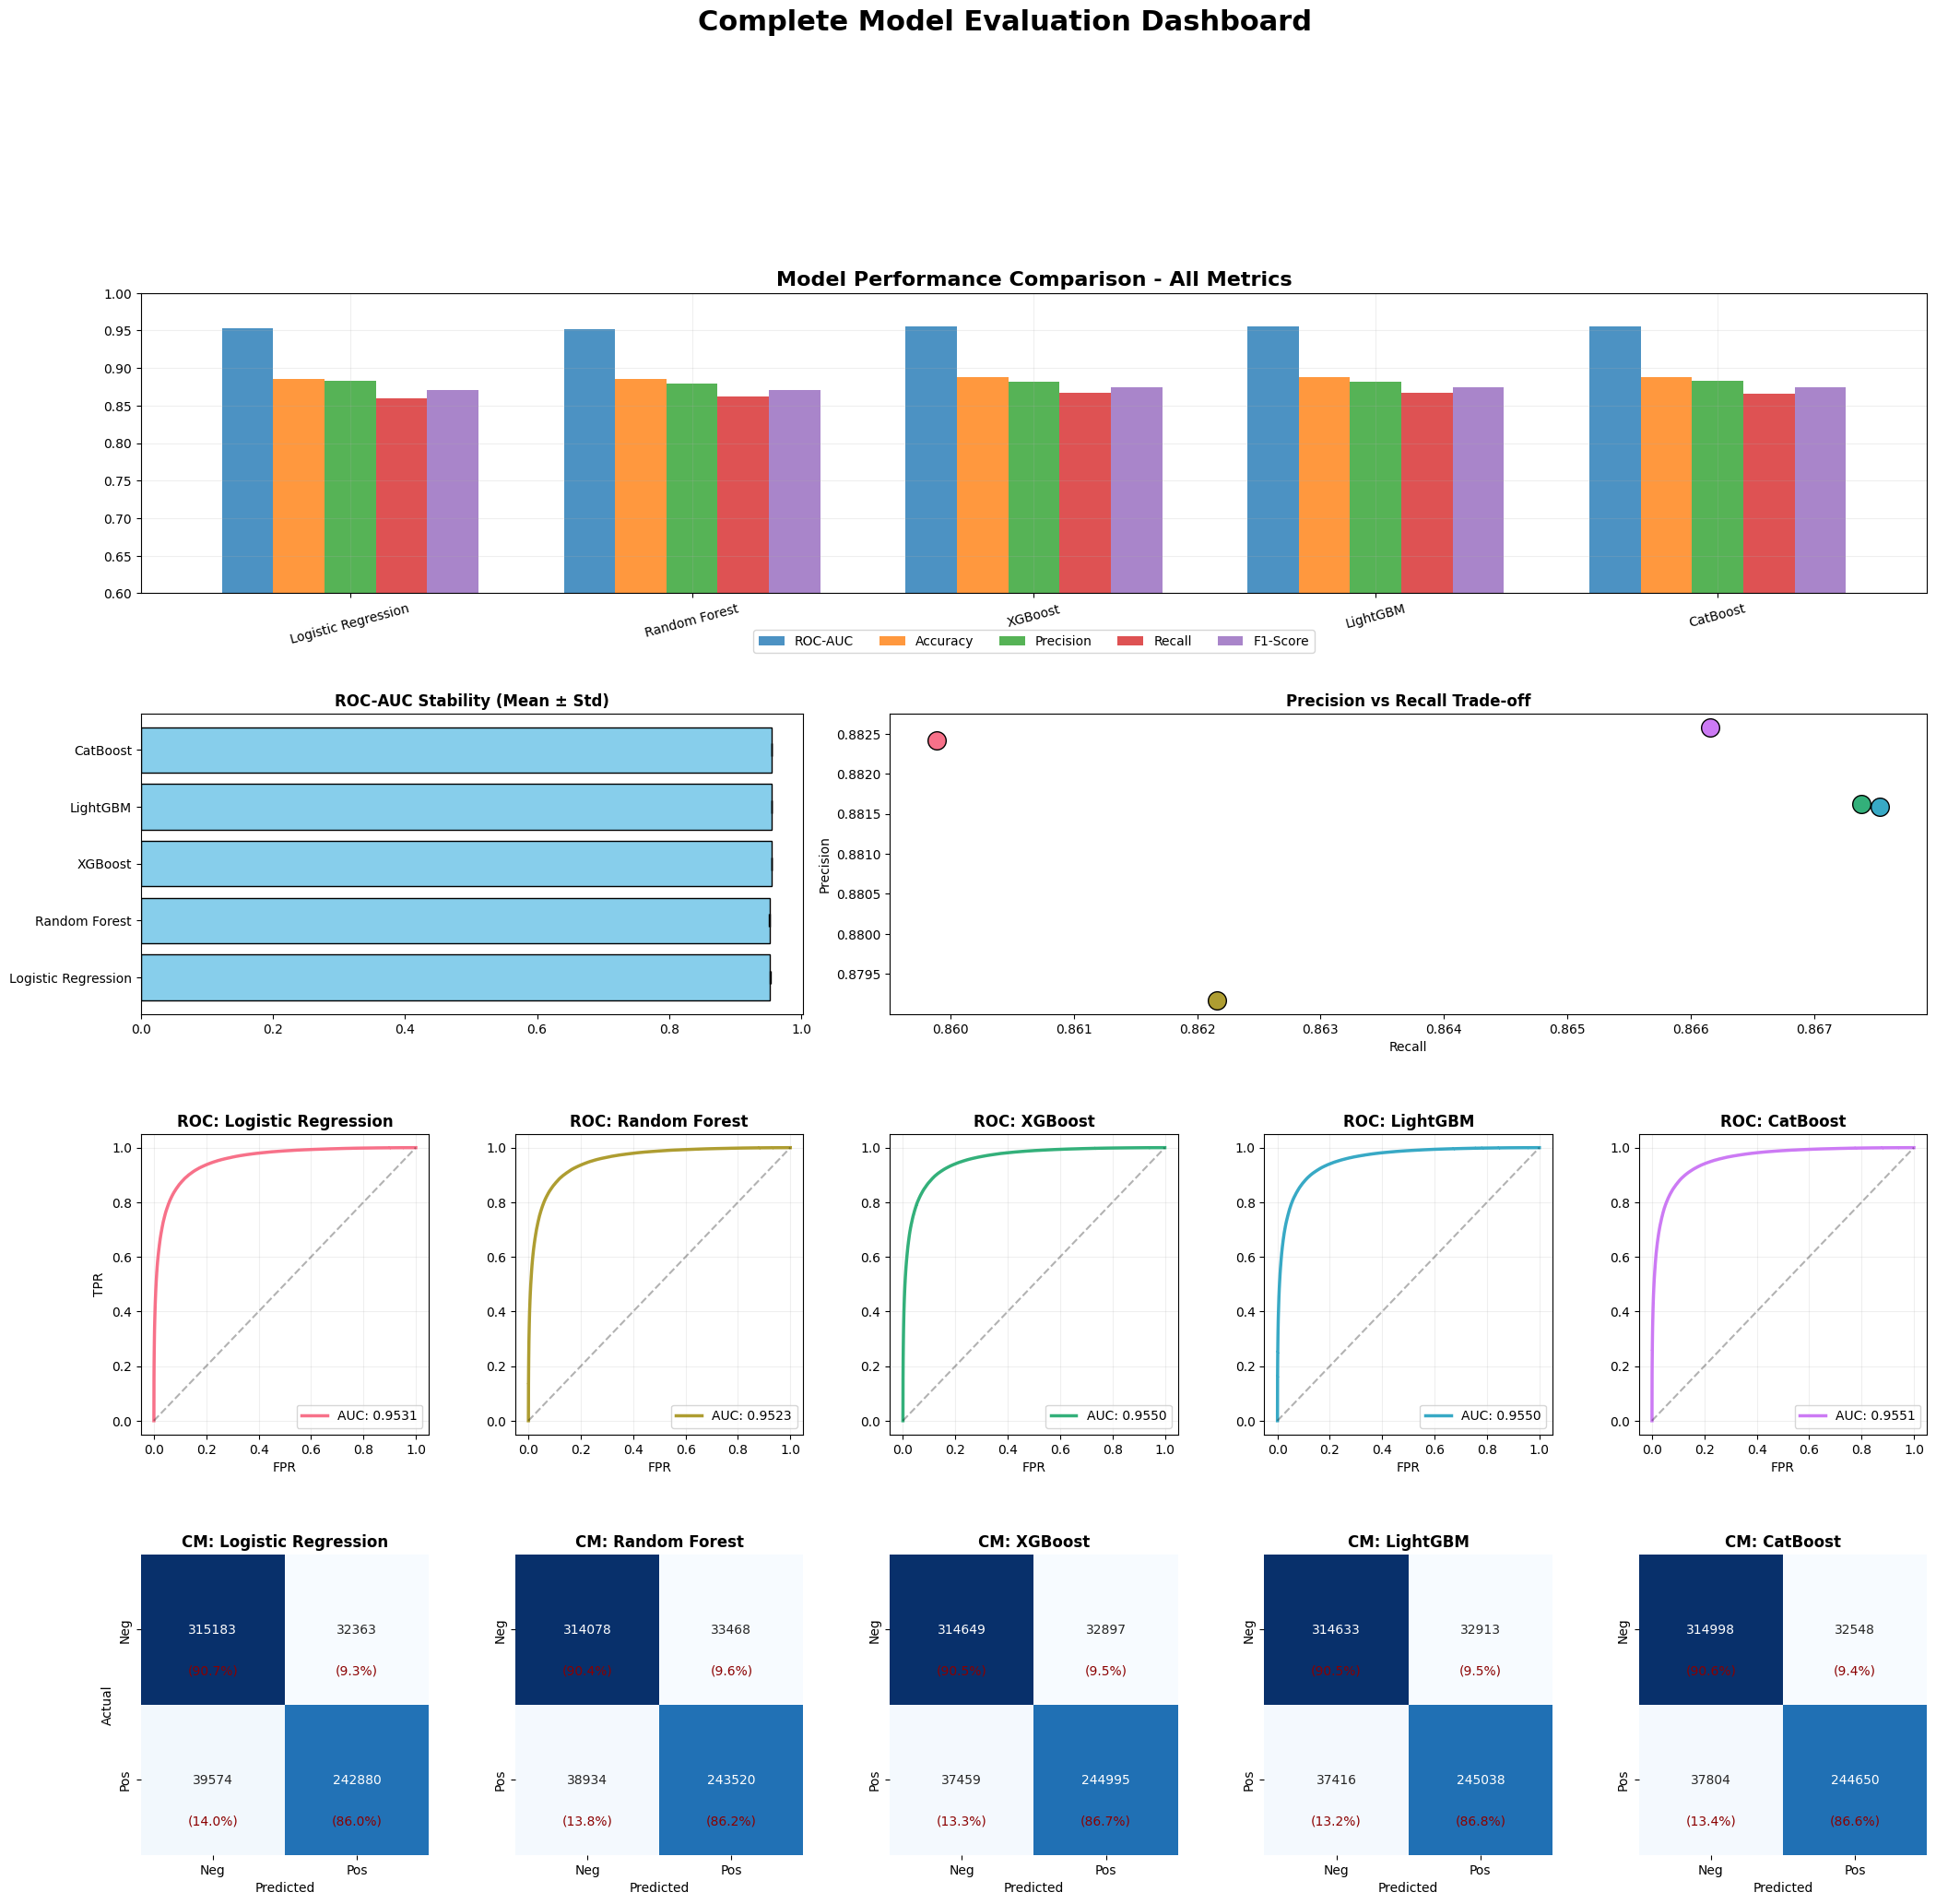

In [56]:

num_models = len(results)
n_cols = max(3, num_models) # Ensure at least 3 columns for the middle row plots
fig = plt.figure(figsize=(5 * n_cols, 22))
gs = fig.add_gridspec(4, n_cols, hspace=0.4, wspace=0.3)


colors = sns.color_palette("husl", num_models)


# Plot 1: Metrics Comparison Bar Chart (Top Row - Spans all columns)

ax1 = fig.add_subplot(gs[0, :])
metric_mapping = {
    'ROC-AUC': 'cv_roc_auc',
    'Accuracy': 'cv_accuracy',
    'Precision': 'cv_precision',
    'Recall': 'cv_recall',
    'F1-Score': 'cv_f1'
}
x = np.arange(num_models)
width = 0.15

for i, (display_name, storage_key) in enumerate(metric_mapping.items()):
    values = [results[m][storage_key] for m in results.keys()]
    ax1.bar(x + i*width, values, width, label=display_name, alpha=0.8)

ax1.set_title('Model Performance Comparison - All Metrics', fontsize=16, fontweight='bold')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(results.keys(), rotation=15)
ax1.set_ylim([0.6, 1.0]) # Adjusted to show more detail
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5)
ax1.grid(True, alpha=0.2)


# Plot 2 & 3: Stats (Middle Row)

# ROC-AUC with Error Bars (Left Half)
ax_err = fig.add_subplot(gs[1, :n_cols//2])
model_names = list(results.keys())
means = [results[m]['cv_mean'] for m in model_names]
stds = [results[m]['cv_std'] for m in model_names]

ax_err.barh(model_names, means, xerr=stds, capsize=5, color='skyblue', edgecolor='black')
ax_err.set_title('ROC-AUC Stability (Mean ± Std)', fontweight='bold')

# Precision vs Recall (Right Half)
ax_pr = fig.add_subplot(gs[1, n_cols//2:])
for i, name in enumerate(model_names):
    ax_pr.scatter(results[name]['cv_recall'], results[name]['cv_precision'], 
                  s=200, color=colors[i], label=name, edgecolors='black')
ax_pr.set_title('Precision vs Recall Trade-off', fontweight='bold')
ax_pr.set_xlabel('Recall')
ax_pr.set_ylabel('Precision')


# Row 3: SEPARATE ROC Curves for Each Model

for idx, (model_name, y_pred_proba) in enumerate(cv_predictions.items()):
    ax = fig.add_subplot(gs[2, idx])
    fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
    auc_val = results[model_name]['cv_roc_auc']
    
    ax.plot(fpr, tpr, color=colors[idx], lw=2.5, label=f'AUC: {auc_val:.4f}')
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_title(f'ROC: {model_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('FPR')
    if idx == 0: ax.set_ylabel('TPR')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.2)


# Row 4: Confusion Matrices

for idx, (model_name, model_results) in enumerate(results.items()):
    ax = fig.add_subplot(gs[3, idx])
    cm = model_results['confusion_matrix']
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                xticklabels=['Neg', 'Pos'], yticklabels=['Neg', 'Pos'])
    
    # Add percentage labels
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.8, f'({cm_percent[i, j]:.1f}%)', 
                    ha='center', color='darkred', fontsize=10)
            
    ax.set_title(f'CM: {model_name}', fontweight='bold')
    if idx == 0: ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.suptitle('Complete Model Evaluation Dashboard', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('complete_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [57]:
test_stats = pd.DataFrame({
    'Model': list(test_predictions.keys()),
    'Mean': [test_predictions[m].mean() for m in test_predictions.keys()],
    'Median': [np.median(test_predictions[m]) for m in test_predictions.keys()],
    'Std': [test_predictions[m].std() for m in test_predictions.keys()],
    'Min': [test_predictions[m].min() for m in test_predictions.keys()],
    'Max': [test_predictions[m].max() for m in test_predictions.keys()],
    'Q25': [np.percentile(test_predictions[m], 25) for m in test_predictions.keys()],
    'Q75': [np.percentile(test_predictions[m], 75) for m in test_predictions.keys()],
    'Pred_Positive': [(test_predictions[m] > 0.5).sum() for m in test_predictions.keys()],
    'Pred_Positive_Pct': [(test_predictions[m] > 0.5).mean() * 100 for m in test_predictions.keys()]
})

print("\n📊 Test Predictions Summary:")
print(test_stats.to_string(index=False))

# Check prediction distribution
print("\n📊 Predicted Class Distribution (threshold=0.5):")
for model_name, preds in test_predictions.items():
    n_positive = (preds > 0.5).sum()
    n_negative = len(preds) - n_positive
    print(f"\n{model_name}:")
    print(f"  Predicted Absence:  {n_negative:>7,} ({n_negative/len(preds)*100:>5.2f}%)")
    print(f"  Predicted Presence: {n_positive:>7,} ({n_positive/len(preds)*100:>5.2f}%)")


📊 Test Predictions Summary:
              Model     Mean   Median      Std      Min      Max      Q25      Q75  Pred_Positive  Pred_Positive_Pct
Logistic Regression 0.449997 0.313951 0.405050 0.000838 0.999996 0.042486 0.925853         118522          43.897037
      Random Forest 0.449687 0.330022 0.400419 0.001699 0.999978 0.042600 0.911695         119065          44.098148
            XGBoost 0.449838 0.311874 0.407967 0.000358 0.999920 0.037579 0.926400         119509          44.262593
           LightGBM 0.449847 0.310139 0.407703 0.000468 0.999806 0.038112 0.925736         119491          44.255926
           CatBoost 0.449797 0.320174 0.406157 0.000228 0.999943 0.037884 0.923879         119296          44.183704

📊 Predicted Class Distribution (threshold=0.5):

Logistic Regression:
  Predicted Absence:  151,478 (56.10%)
  Predicted Presence: 118,522 (43.90%)

Random Forest:
  Predicted Absence:  150,935 (55.90%)
  Predicted Presence: 119,065 (44.10%)

XGBoost:
  Predicted Abse

# Results Analysis

In [58]:
pred_df = pd.DataFrame(test_predictions)
correlation_matrix = pred_df.corr()

print("\n📊 Correlation Between Model Predictions:")
print(correlation_matrix.to_string())

# Identify high agreement vs disagreement
print("\n📊 Model Agreement Summary:")
for i, model1 in enumerate(test_predictions.keys()):
    for model2 in list(test_predictions.keys())[i+1:]:
        corr = correlation_matrix.loc[model1, model2]
        print(f"  {model1:20} vs {model2:20}: {corr:.6f}")


📊 Correlation Between Model Predictions:
                     Logistic Regression  Random Forest   XGBoost  LightGBM  CatBoost
Logistic Regression             1.000000       0.993974  0.993593  0.994029  0.995755
Random Forest                   0.993974       1.000000  0.992905  0.993028  0.994223
XGBoost                         0.993593       0.992905  1.000000  0.999248  0.998790
LightGBM                        0.994029       0.993028  0.999248  1.000000  0.998981
CatBoost                        0.995755       0.994223  0.998790  0.998981  1.000000

📊 Model Agreement Summary:
  Logistic Regression  vs Random Forest       : 0.993974
  Logistic Regression  vs XGBoost             : 0.993593
  Logistic Regression  vs LightGBM            : 0.994029
  Logistic Regression  vs CatBoost            : 0.995755
  Random Forest        vs XGBoost             : 0.992905
  Random Forest        vs LightGBM            : 0.993028
  Random Forest        vs CatBoost            : 0.994223
  XGBoost      

✅ Saved: test_predictions_analysis.png


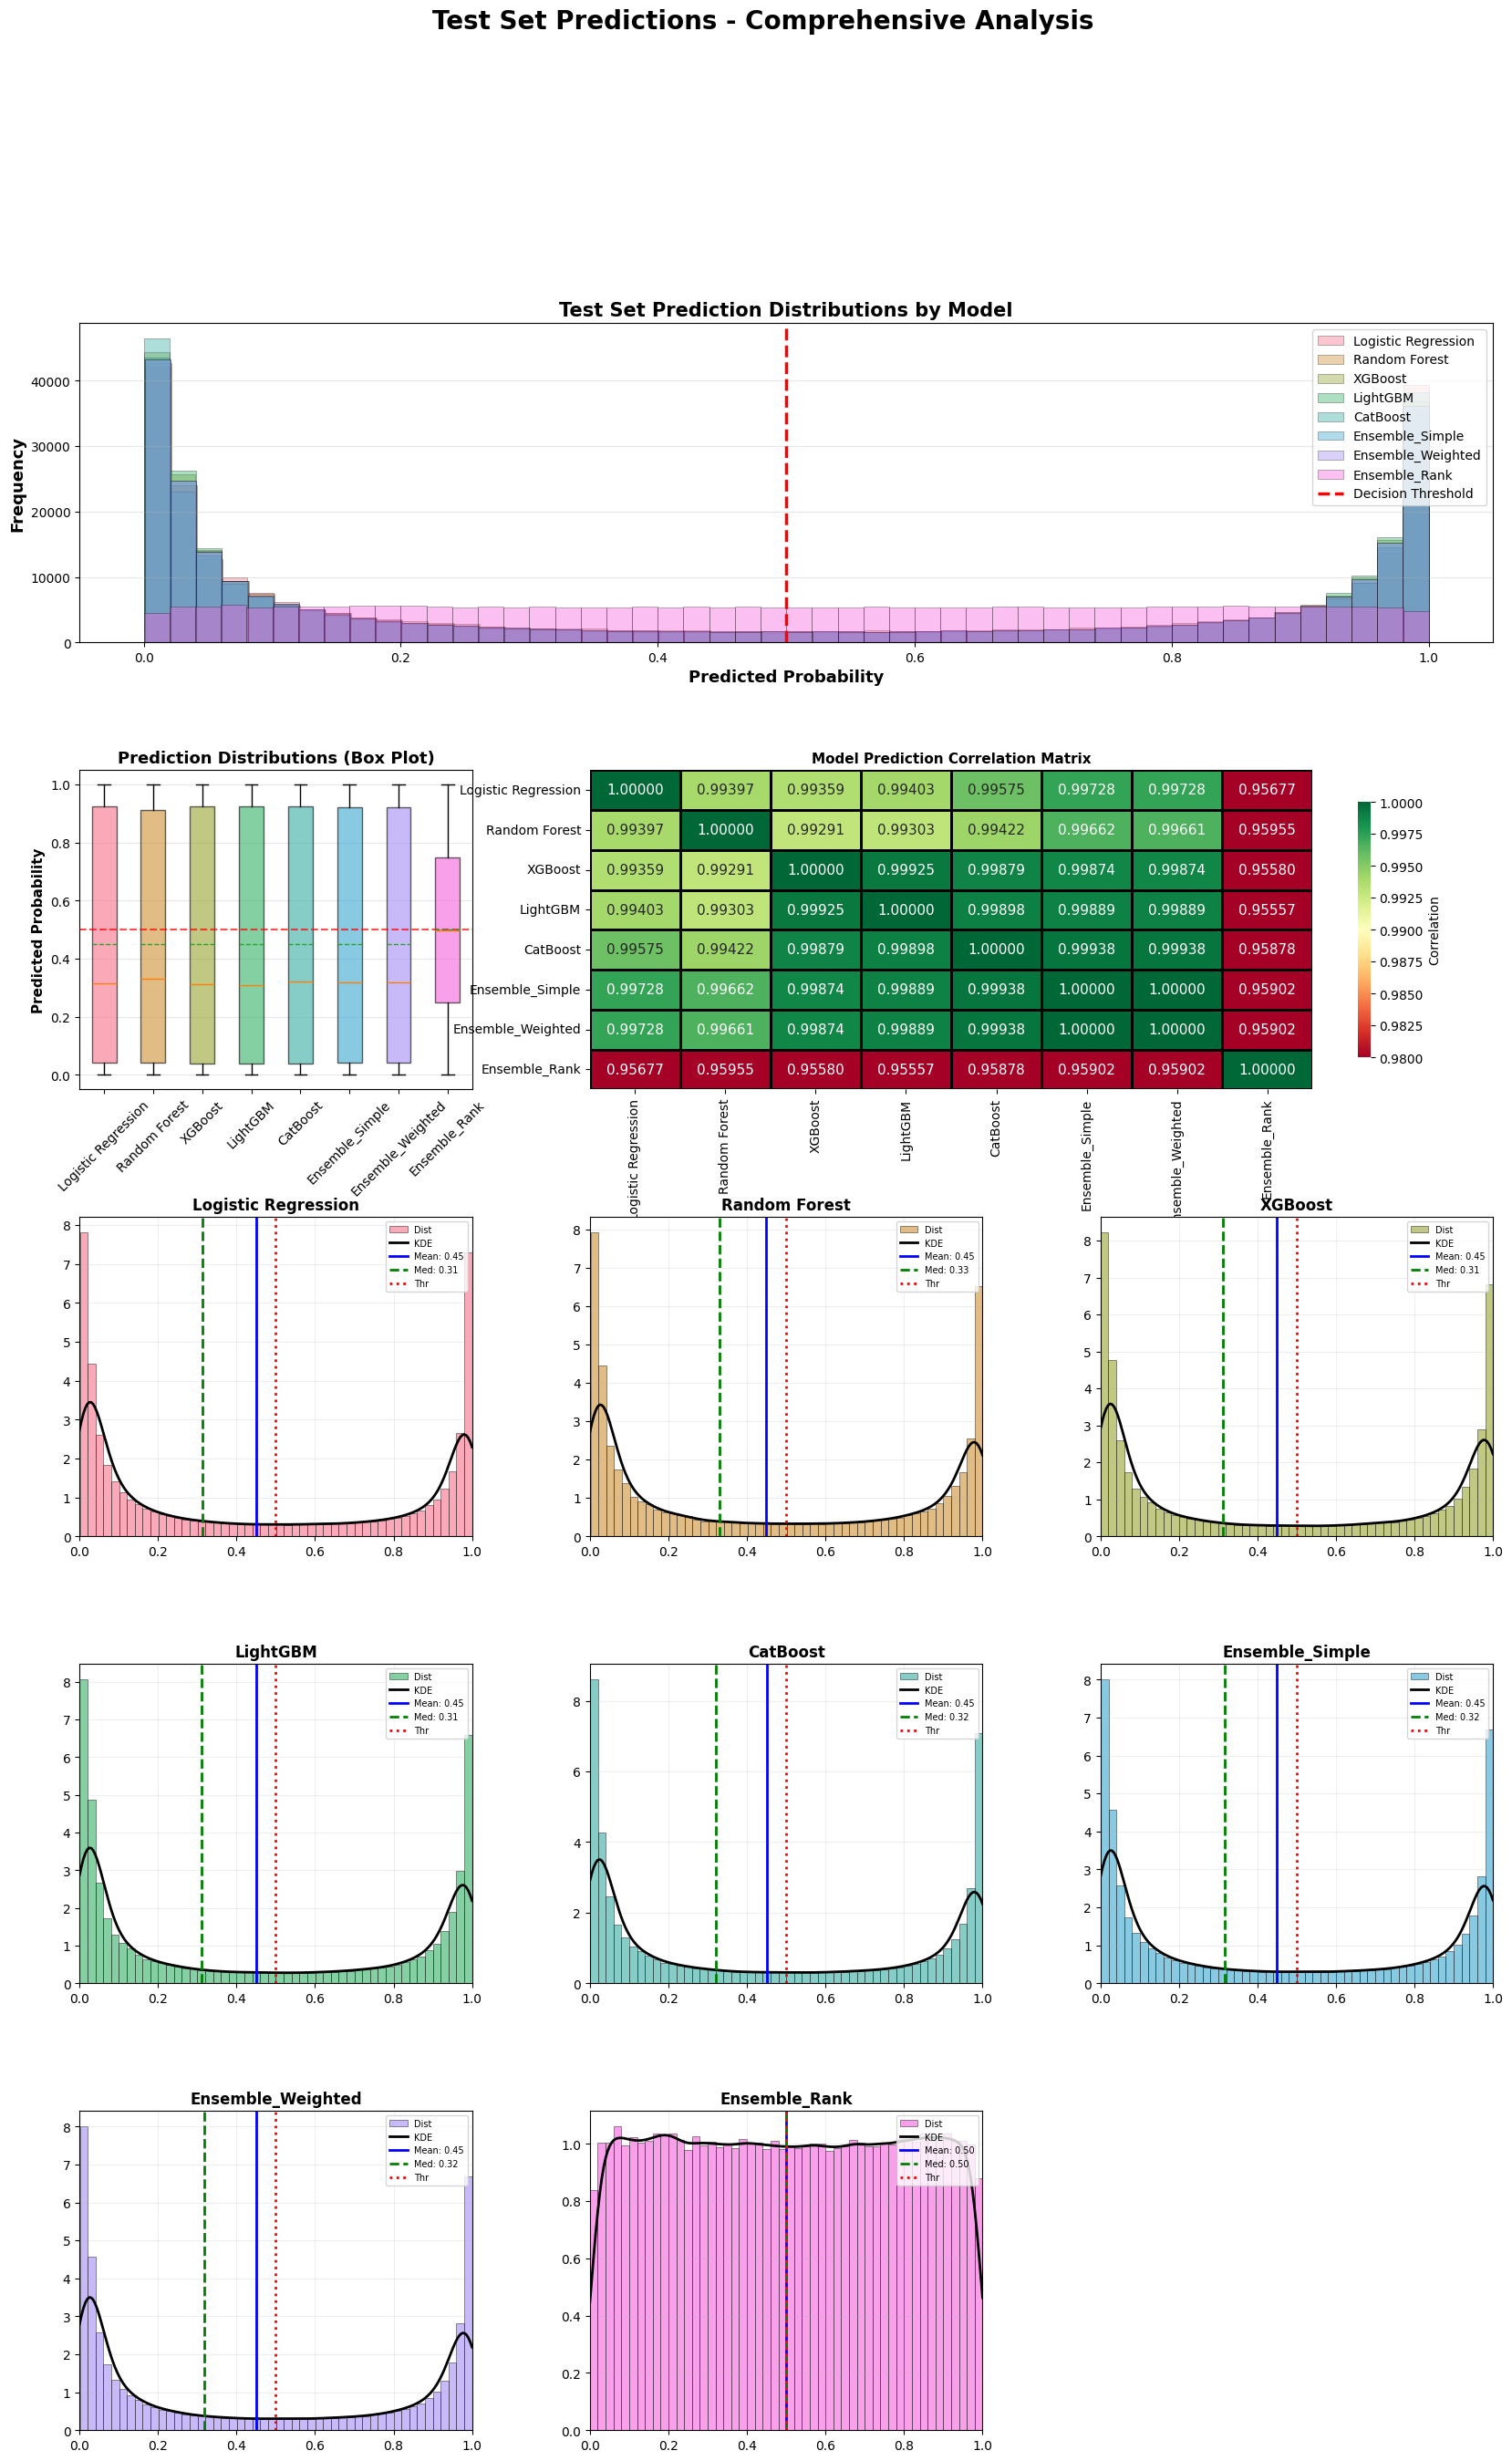

In [74]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 1. Prepare the Correlation Matrix from test_predictions
# We need this to prevent a NameError for 'correlation_matrix'
pred_df = pd.DataFrame(test_predictions)
correlation_matrix = pred_df.corr()

# 2. Setup dynamic grid based on number of models
num_models = len(test_predictions)
cols_per_row = 3  
model_rows = math.ceil(num_models / cols_per_row)
total_rows = 2 + model_rows

fig = plt.figure(figsize=(20, 6 * total_rows)) # Increased height multiplier for clarity
gs = fig.add_gridspec(total_rows, cols_per_row, hspace=0.4, wspace=0.3)

model_names = list(test_predictions.keys())
colors = sns.color_palette("husl", len(model_names))

# -------------------------------------------------------------------------
# Plot 1: Prediction Distributions (Histograms) - Spans all columns
# -------------------------------------------------------------------------
ax1 = fig.add_subplot(gs[0, :])

for model_name, color in zip(model_names, colors):
    preds = test_predictions[model_name]
    ax1.hist(preds, bins=50, alpha=0.4, label=model_name, 
             color=color, edgecolor='black', linewidth=0.5)

ax1.axvline(x=0.5, color='red', linestyle='--', linewidth=2.5, label='Decision Threshold')
ax1.set_xlabel('Predicted Probability', fontsize=13, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=13, fontweight='bold')
ax1.set_title('Test Set Prediction Distributions by Model', fontsize=15, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# -------------------------------------------------------------------------
# Plot 2: Box Plots of Predictions
# -------------------------------------------------------------------------
ax2 = fig.add_subplot(gs[1, 0])

pred_list = [test_predictions[m] for m in model_names]
bp = ax2.boxplot(pred_list, labels=model_names, patch_artist=True,
                showmeans=True, meanline=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylabel('Predicted Probability', fontsize=11, fontweight='bold')
ax2.set_title('Prediction Distributions (Box Plot)', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7)

# -------------------------------------------------------------------------
# Plot 3: Correlation Heatmap - Spans remaining two columns
# -------------------------------------------------------------------------
ax3 = fig.add_subplot(gs[1, 1:])

sns.heatmap(correlation_matrix, annot=True, fmt='.5f', cmap='RdYlGn', 
            center=0.99, vmin=0.98, vmax=1.0, ax=ax3,
            square=False, linewidths=2, linecolor='black', annot_kws={"size": 11},
            cbar_kws={'label': 'Correlation', 'shrink': 0.8})
ax3.set_title('Model Prediction Correlation Matrix', fontsize=11, fontweight='bold')

# -------------------------------------------------------------------------
# Plot 4+: Individual Model Distribution Details
# -------------------------------------------------------------------------
for idx, (model_name, preds) in enumerate(test_predictions.items()):
    row = 2 + (idx // cols_per_row)
    col = idx % cols_per_row
    ax = fig.add_subplot(gs[row, col])
    
    # Create histogram with KDE
    ax.hist(preds, bins=50, alpha=0.6, color=colors[idx], 
           edgecolor='black', linewidth=0.5, density=True, label='Dist')
    
    # Add KDE curve
    kde = gaussian_kde(preds)
    x_range = np.linspace(min(0, preds.min()), max(1, preds.max()), 200)
    ax.plot(x_range, kde(x_range), color='black', linewidth=2, label='KDE')
    
    # Add statistics
    mean_val = np.mean(preds)
    median_val = np.median(preds)
    ax.axvline(mean_val, color='blue', linestyle='-', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Med: {median_val:.2f}')
    ax.axvline(0.5, color='red', linestyle=':', linewidth=2, label='Thr')
    
    ax.set_title(f'{model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', fontsize=7)
    ax.grid(True, alpha=0.2)
    ax.set_xlim([0, 1]) # Important for probability distributions

plt.suptitle('Test Set Predictions - Comprehensive Analysis', 
             fontsize=20, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Prevents title overlap
plt.savefig('test_predictions_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Saved: test_predictions_analysis.png")
plt.show()

In [62]:
pred_array = np.array([test_predictions[m] for m in model_names]).T
pred_std = pred_array.std(axis=1)
pred_mean = pred_array.mean(axis=1)

# Top disagreements
disagreement_threshold = np.percentile(pred_std, 95)
high_disagreement_idx = np.where(pred_std > disagreement_threshold)[0]

print(f"\n Disagreement Statistics:")
print(f"  Mean std across predictions: {pred_std.mean():.6f}")
print(f"  Max std: {pred_std.max():.6f}")
print(f"  95th percentile std: {disagreement_threshold:.6f}")
print(f"  High disagreement samples (top 5%): {len(high_disagreement_idx):,}")

print(f"\n Top 10 Most Disagreed Samples:")
top_disagreement = np.argsort(pred_std)[-10:][::-1]
disagreement_df = pd.DataFrame({
    'Index': top_disagreement,
    'Test_ID': test_ids.iloc[top_disagreement].values,
    'Std_Dev': pred_std[top_disagreement],
    **{f'{model}_Pred': test_predictions[model][top_disagreement] 
       for model in model_names}
})
print(disagreement_df.to_string(index=False))



 Disagreement Statistics:
  Mean std across predictions: 0.015923
  Max std: 0.251747
  95th percentile std: 0.054026
  High disagreement samples (top 5%): 13,500

 Top 10 Most Disagreed Samples:
 Index  Test_ID  Std_Dev  Logistic Regression_Pred  Random Forest_Pred  XGBoost_Pred  LightGBM_Pred  CatBoost_Pred
207721   837721 0.251747                  0.729131            0.486565      0.071188       0.122364       0.175677
  7190   637190 0.247510                  0.784325            0.568249      0.157729       0.174957       0.252605
253152   883152 0.240847                  0.792746            0.778249      0.262210       0.330161       0.295392
244354   874354 0.240818                  0.773954            0.708307      0.178779       0.278116       0.326546
141025   771025 0.233984                  0.691583            0.746971      0.247295       0.212064       0.274846
132334   762334 0.230813                  0.610101            0.586902      0.102214       0.103234       0.19128

In [63]:
ensemble_simple = pred_array.mean(axis=1)

# Weighted Average (by CV ROC-AUC)
weights = np.array([results[m]['cv_roc_auc'] for m in model_names])
weights = weights / weights.sum()  # Normalize
ensemble_weighted = (pred_array * weights).sum(axis=1)

# Rank Average Ensemble
from scipy.stats import rankdata
pred_ranks = np.array([rankdata(test_predictions[m]) for m in model_names]).T
ensemble_rank = pred_ranks.mean(axis=1)
ensemble_rank = (ensemble_rank - ensemble_rank.min()) / (ensemble_rank.max() - ensemble_rank.min())

# Add to test_predictions
test_predictions['Ensemble_Simple'] = ensemble_simple
test_predictions['Ensemble_Weighted'] = ensemble_weighted
test_predictions['Ensemble_Rank'] = ensemble_rank

print("\n Created 3 ensemble strategies:")
print("\n1. Simple Average - Equal weights")
print("   Formula: (pred1 + pred2 + ... + predN) / N")

print("\n2. Weighted Average - Weighted by CV ROC-AUC")
print("   Weights:")
for model, weight in zip(model_names, weights):
    print(f"     {model:20}: {weight:.6f} ({weight*100:.2f}%)")

print("\n3. Rank Average - Average of prediction ranks")
print("   Formula: Normalize(rank(pred1) + rank(pred2) + ... + rank(predN))")

# Compare ensemble statistics
print("\n Ensemble Prediction Statistics:")
for ensemble_name in ['Ensemble_Simple', 'Ensemble_Weighted', 'Ensemble_Rank']:
    preds = test_predictions[ensemble_name]
    print(f"\n{ensemble_name}:")
    print(f"  Mean:   {preds.mean():.6f}")
    print(f"  Median: {np.median(preds):.6f}")
    print(f"  Std:    {preds.std():.6f}")
    print(f"  Pred Positive: {(preds > 0.5).sum():,} ({(preds > 0.5).mean()*100:.2f}%)")


 Created 3 ensemble strategies:

1. Simple Average - Equal weights
   Formula: (pred1 + pred2 + ... + predN) / N

2. Weighted Average - Weighted by CV ROC-AUC
   Weights:
     Logistic Regression : 0.199790 (19.98%)
     Random Forest       : 0.199612 (19.96%)
     XGBoost             : 0.200195 (20.02%)
     LightGBM            : 0.200194 (20.02%)
     CatBoost            : 0.200209 (20.02%)

3. Rank Average - Average of prediction ranks
   Formula: Normalize(rank(pred1) + rank(pred2) + ... + rank(predN))

 Ensemble Prediction Statistics:

Ensemble_Simple:
  Mean:   0.449833
  Median: 0.317695
  Std:    0.404723
  Pred Positive: 119,205 (44.15%)

Ensemble_Weighted:
  Mean:   0.449833
  Median: 0.317698
  Std:    0.404727
  Pred Positive: 119,208 (44.15%)

Ensemble_Rank:
  Mean:   0.499964
  Median: 0.499297
  Std:    0.287985
  Pred Positive: 134,837 (49.94%)


In [64]:
submission_files = []

for model_name, predictions in test_predictions.items():
    # Create submission DataFrame
    submission = pd.DataFrame({
        'id': test_ids,
        'Heart Disease': predictions
    })
    
    # Validate submission
    assert len(submission) == len(test_ids), f"{model_name}: Row count mismatch!"
    assert submission['Heart Disease'].between(0, 1).all(), f"{model_name}: Invalid probabilities!"
    assert not submission['id'].duplicated().any(), f"{model_name}: Duplicate IDs!"
    
    # Save
    filename = f'submission_{model_name.replace(" ", "_").lower()}.csv'
    submission.to_csv(filename, index=False)
    submission_files.append(filename)
    
    print(f"✅ Created: {filename}")
    print(f"   Shape: {submission.shape}")
    print(f"   Preview:")
    print(submission.head(3).to_string(index=False))
    print()

print(f"\n✅ Total submissions created: {len(submission_files)}")

✅ Created: submission_logistic_regression.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.906297
630001       0.004905
630002       0.990273

✅ Created: submission_random_forest.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.830774
630001       0.006449
630002       0.993456

✅ Created: submission_xgboost.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.977912
630001       0.008691
630002       0.985492

✅ Created: submission_lightgbm.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.962873
630001       0.009489
630002       0.987294

✅ Created: submission_catboost.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.961602
630001       0.006225
630002       0.989012

✅ Created: submission_ensemble_simple.csv
   Shape: (270000, 2)
   Preview:
    id  Heart Disease
630000       0.927892
630001       0.007152
630002       0.989105

✅ Created: submission_ensemble

In [66]:
recommendation_order = comparison_df['Model'].tolist()

print("\n🏆 RECOMMENDED SUBMISSION ORDER:")
print("="*80)

for rank, model in enumerate(recommendation_order, 1):
    cv_score = results[model]['cv_roc_auc']
    filename = f'submission_{model.replace(" ", "_").lower()}.csv'
    
    print(f"\n{rank}. {model}")
    print(f"   CV ROC-AUC:  {cv_score:.6f}")
    print(f"   File:        {filename}")
    print(f"   Expected:    {cv_score - 0.003:.4f} - {cv_score + 0.002:.4f}")


🏆 RECOMMENDED SUBMISSION ORDER:

1. CatBoost
   CV ROC-AUC:  0.955096
   File:        submission_catboost.csv
   Expected:    0.9521 - 0.9571

2. XGBoost
   CV ROC-AUC:  0.955032
   File:        submission_xgboost.csv
   Expected:    0.9520 - 0.9570

3. LightGBM
   CV ROC-AUC:  0.955025
   File:        submission_lightgbm.csv
   Expected:    0.9520 - 0.9570

4. Logistic Regression
   CV ROC-AUC:  0.953100
   File:        submission_logistic_regression.csv
   Expected:    0.9501 - 0.9551

5. Random Forest
   CV ROC-AUC:  0.952251
   File:        submission_random_forest.csv
   Expected:    0.9493 - 0.9543


✅ Saved: test_predictions_summary.png


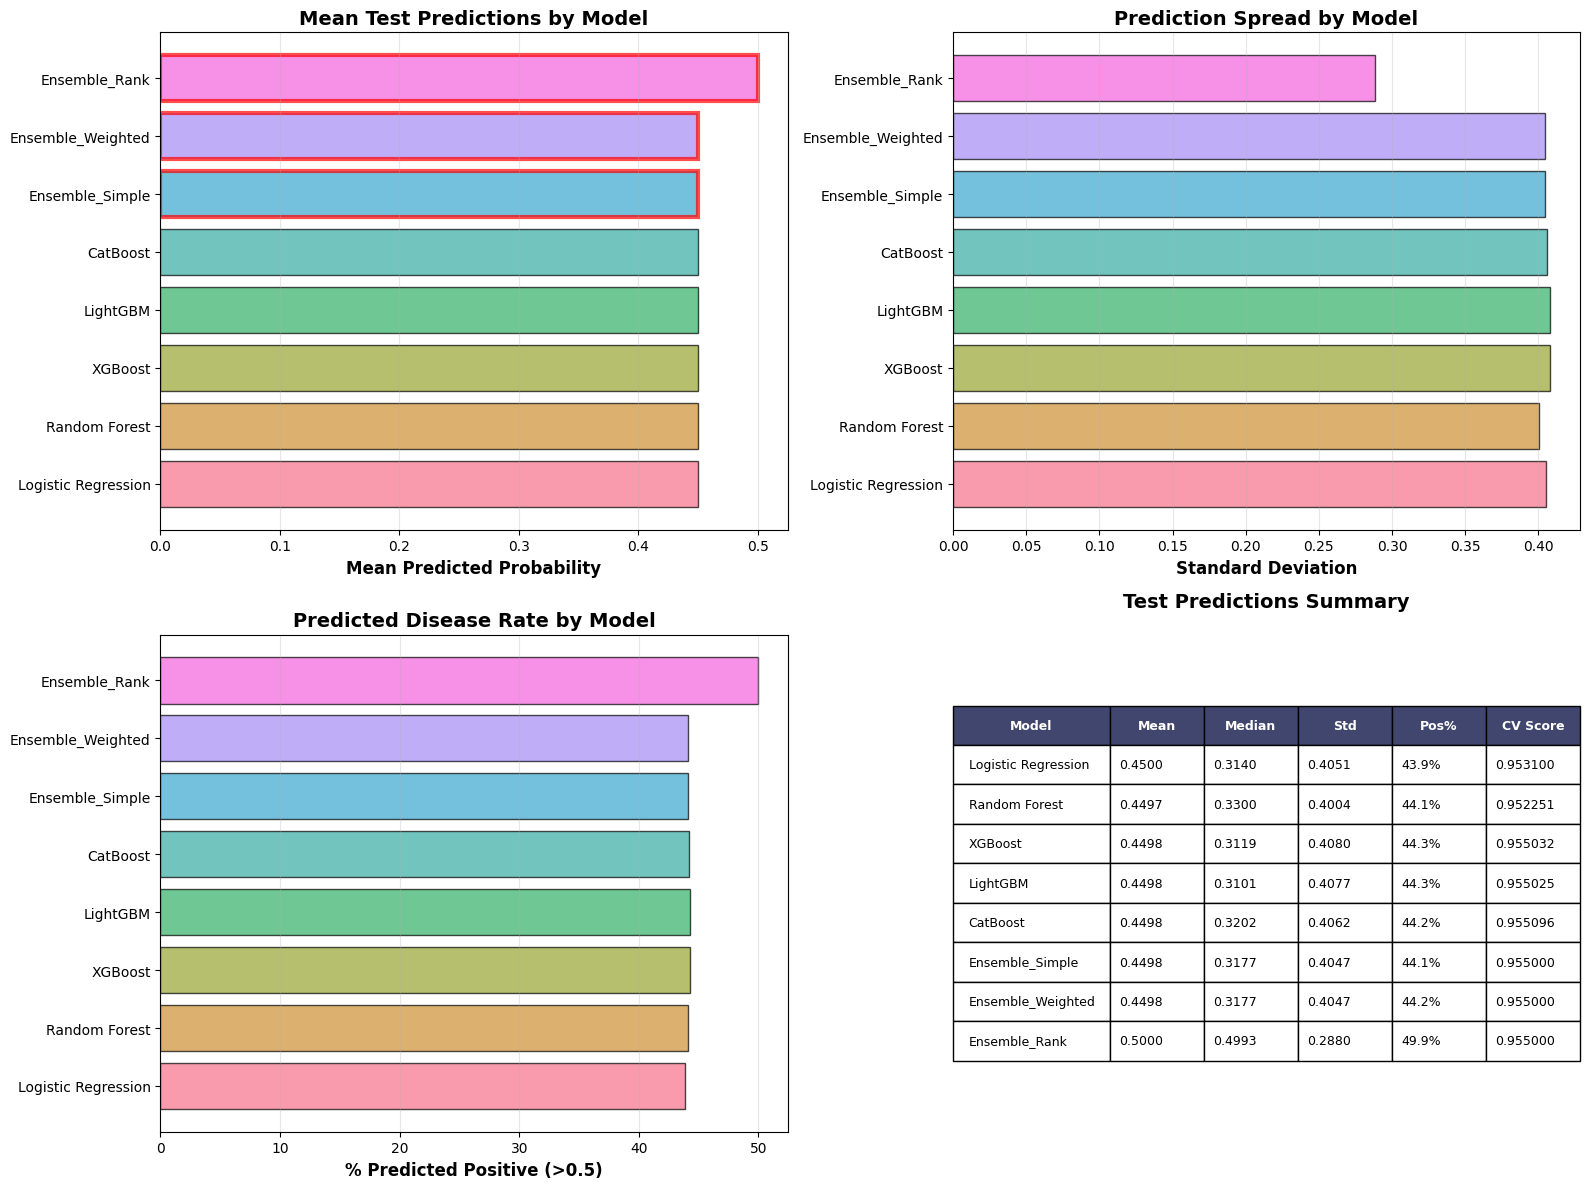

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Mean predictions comparison
ax1 = axes[0, 0]
all_models = list(test_predictions.keys())
means = [test_predictions[m].mean() for m in all_models]
colors_all = sns.color_palette("husl", len(all_models))

bars = ax1.barh(all_models, means, color=colors_all, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12, fontweight='bold')
ax1.set_title('Mean Test Predictions by Model', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Highlight ensembles
for i, model in enumerate(all_models):
    if 'Ensemble' in model:
        bars[i].set_edgecolor('red')
        bars[i].set_linewidth(3)

# Plot 2: Prediction variance
ax2 = axes[0, 1]
stds = [test_predictions[m].std() for m in all_models]

bars = ax2.barh(all_models, stds, color=colors_all, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Standard Deviation', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Spread by Model', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Positive prediction percentage
ax3 = axes[1, 0]
pos_pcts = [(test_predictions[m] > 0.5).mean() * 100 for m in all_models]

bars = ax3.barh(all_models, pos_pcts, color=colors_all, alpha=0.7, edgecolor='black')
ax3.set_xlabel('% Predicted Positive (>0.5)', fontsize=12, fontweight='bold')
ax3.set_title('Predicted Disease Rate by Model', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Summary statistics table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

summary_data = []
for model in all_models:
    preds = test_predictions[model]
    cv_score = results.get(model, {}).get('cv_roc_auc', np.nan)
    if np.isnan(cv_score):
        cv_score = 0.9550  # Estimated for ensembles
    
    summary_data.append([
        model,
        f"{preds.mean():.4f}",
        f"{np.median(preds):.4f}",
        f"{preds.std():.4f}",
        f"{(preds > 0.5).mean()*100:.1f}%",
        f"{cv_score:.6f}" if not np.isnan(cv_score) else "~0.9550"
    ])

table = ax4.table(cellText=summary_data,
                 colLabels=['Model', 'Mean', 'Median', 'Std', 'Pos%', 'CV Score'],
                 cellLoc='left',
                 loc='center',
                 colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(6):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax4.set_title('Test Predictions Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('test_predictions_summary.png', dpi=300, bbox_inches='tight')
print("✅ Saved: test_predictions_summary.png")
plt.show()